In [1]:
!pip install -U -q kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 7.5 MB/s eta 0:00:00


In [2]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_47d98a945ada6a7d62bd428a7d8ef892"

In [3]:
import kagglehub

dataset_path = kagglehub.dataset_download(
    "shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset"
)
print("Dataset downloaded to:", dataset_path)


100%|██████████| 22.0M/22.0M [00:01<00:00, 14.5MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset/versions/1


In [4]:
import os
os.listdir(dataset_path)

['dhaka_air_quality_2000_2025.csv']

In [5]:
import pandas as pd
df = pd.read_csv(
    "/root/.cache/kagglehub/datasets/shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset/versions/1/dhaka_air_quality_2000_2025.csv"
)
df.head()

datetime         AQI      PM2.5        PM10         O3  \
0  2000-01-01 00:00:00  121.861086  44.200712   93.224101  20.586862   
1  2000-01-01 01:00:00   99.598077  35.212704   78.893066  22.429471   
2  2000-01-01 02:00:00  132.852834  48.575428  118.693959  37.838094   
3  2000-01-01 03:00:00  154.588259  64.208516   86.427166  26.747684   
4  2000-01-01 04:00:00  114.102260  41.112699   70.193382  33.192759   

         NO2        SO2        CO  Temperature   Humidity  Wind_Speed  \
0  15.391414  28.219932  1.049477    20.956667  71.272569    8.375675   
1  26.824534  24.385188  0.943859    13.761031  42.616871   10.880553   
2  33.403493  28.951413  0.887131    20.216907  59.169387   15.041183   
3  12.137395  26.950990  0.793261    18.642574  62.756439    9.904413   
4  25.313206  20.741976  1.059887    18.834718  56.369280   14.632070   

      Pressure  
0  1011.742574  
1  1010.949986  
2  1012.065387  
3  1010.162227  
4  1007.067421

**AQI** : Air Quality Index, a composite measure of pollution levels (higher values indicate worse air quality).

**PM2.5 & PM10** : Particulate Matter concentrations (fine and coarse particles, in µg/m³).

**O3, NO2, SO2, CO** : Concentrations of Ozone, Nitrogen Dioxide, Sulfur Dioxide, and Carbon Monoxide (in µg/m³ or ppm).

**Temperature, Humidity, Wind_Speed, Pressure** : Meteorological factors influencing air quality (in °C, %, m/s, hPa).




In [6]:
len(df)

225816

This rich dataset allows us to analyze long-term trends, seasonal variations, and correlations between pollutants and weather conditions in one of the world's most polluted cities.

# **`Problem Framing`**
Air pollution in Dhaka poses significant health risks, contributing to respiratory diseases, cardiovascular issues, and premature deaths. Framing the problem: How can we leverage this historical data to predict future AQI levels and identify key drivers of pollution ❓

### **Objectives :**
Visualize trends (e.g., via lineplots of AQI over time), engineer features (e.g., pollutant ratios), build ML models (e.g., XGBoost for classification of AQI categories), and deploy deep learning (e.g., LSTM for time-series forecasting).

### **Challenges :**
Handling time-series data, dealing with potential imbalances in AQI categories, and improving model accuracy through tuning and advanced techniques.

### **Impact :**
Insights could inform policy for emission controls, urban planning, and public health alerts in Dhaka.

## **Data Cleaning**

**Let's Breathe Life into the Data!**

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Handling Missing Values
missing_values = df.isna().sum()
print('Missing Values : \n', missing_values)

Missing Values : 
 AQI            0
PM2.5          0
PM10           0
O3             0
NO2            0
SO2            0
CO             0
Temperature    0
Humidity       0
Wind_Speed     0
Pressure       0
dtype: int64


In [8]:
# Impute missing numerical values with median

numerical_cols = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [9]:
# Handle Outliers using IQR method
def remove_outliers(df,column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  df[column] = df[column].clip(Q1-1.5*IQR, Q3+1.5*IQR)
  return df

for col in numerical_cols:
  df = remove_outliers(df,col)

In [10]:
# Check for Invalid Values
for col in ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']:
  df[col] = df[col].clip(lower=0)

## **Feature Engineering**

In [11]:
# Extract Temporal features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week

# Create pollutant ratios
df['PM2.5_to_PM10'] = df['PM2.5'] / (df['PM10'] + 1e-6)
df['NO2_to_SO2'] = df['NO2']/(df['SO2'] + 1e-6)

# Create lagged features for AQI (previous 1,3,6 hours)
df['AQI_lag1'] = df['AQI'].shift(1)
df['AQI_lag3'] = df['AQI'].shift(3)
df['AQI_lag6'] = df['AQI'].shift(6)
# Impute the lagged features with median
df['AQI_lag1'] = df['AQI_lag1'].fillna(df['AQI_lag1'].median())
df['AQI_lag3'] = df['AQI_lag3'].fillna(df['AQI_lag3'].median())
df['AQI_lag6'] = df['AQI_lag6'].fillna(df['AQI_lag6'].median())

# Categorize the AQI features
def categorize_aqi(aqi):
    if aqi <= 50:
        return 0      # Good
    elif aqi <= 100:
        return 1      # Moderate
    elif aqi <= 150:
        return 2      # Unhealthy for Sensitive Groups
    elif aqi <= 200:
        return 3      # Unhealthy
    elif aqi <= 300:
        return 4      # Very Unhealthy
    else:
        return 5      # Hazardous

df['AQI_category'] = df['AQI'].apply(categorize_aqi)

In [12]:
# Scale Numerical Features
scaler = StandardScaler()
scaling_cols = numerical_cols + ['PM2.5_to_PM10', 'NO2_to_SO2', 'AQI_lag1', 'AQI_lag3', 'AQI_lag6']
df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

df.dropna(inplace=True)
df.to_csv('dhaka_air_quality_cleaned.csv')

## **Exploratory Data Analysis**

In [13]:
df = pd.read_csv(
    "/content/dhaka_air_quality_cleaned.csv"
)
df.head(2)

datetime       AQI     PM2.5      PM10        O3       NO2  \
0  2000-01-01 00:00:00 -1.244425 -1.096926 -0.899133 -1.627609 -1.553118   
1  2000-01-01 01:00:00 -1.780779 -1.257775 -1.049938 -1.525778 -0.613435   

        SO2        CO  Temperature  Humidity  ...  month  day  hour  \
0  0.677933 -1.111451    -0.988978  0.117803  ...      1    1     0   
1  0.174518 -1.308787    -2.388315 -2.580344  ...      1    1     1   

   day_of_week  PM2.5_to_PM10  NO2_to_SO2  AQI_lag1  AQI_lag3  AQI_lag6  \
0            5      -0.790714   -1.242279 -0.048656  -0.04867  -0.04866   
1            5      -0.948303   -0.618826 -1.244423  -0.04867  -0.04866   

   AQI_category  
0             2  
1             1  

[2 rows x 23 columns]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225816 entries, 0 to 225815
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   datetime       225816 non-null  object 
 1   AQI            225816 non-null  float64
 2   PM2.5          225816 non-null  float64
 3   PM10           225816 non-null  float64
 4   O3             225816 non-null  float64
 5   NO2            225816 non-null  float64
 6   SO2            225816 non-null  float64
 7   CO             225816 non-null  float64
 8   Temperature    225816 non-null  float64
 9   Humidity       225816 non-null  float64
 10  Wind_Speed     225816 non-null  float64
 11  Pressure       225816 non-null  float64
 12  year           225816 non-null  int64  
 13  month          225816 non-null  int64  
 14  day            225816 non-null  int64  
 15  hour           225816 non-null  int64  
 16  day_of_week    225816 non-null  int64  
 17  PM2.5_to_PM10  225816 non-nul

In [15]:
df.describe()

AQI         PM2.5          PM10            O3           NO2  \
count  2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05   
mean  -4.108144e-16 -6.444147e-16  1.691589e-16 -1.016967e-16  3.020694e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -1.972787e+00 -1.798459e+00 -1.774898e+00 -2.489007e+00 -2.407184e+00   
25%   -4.822888e-01 -7.759724e-01 -7.707149e-01 -7.133450e-01 -7.122474e-01   
50%   -4.865064e-02 -1.645935e-01 -1.503336e-01 -9.101584e-02 -4.143654e-02   
75%    5.113764e-01  6.249788e-01  6.462444e-01  6.138592e-01  6.836237e-01   
max    2.001874e+00  2.586045e+00  2.329062e+00  2.604665e+00  2.777430e+00   

                SO2            CO   Temperature      Humidity    Wind_Speed  \
count  2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05   
mean  -2.074210e-16  4.873386e-16 -2.940142e-16 -1.540554e-15  5.369284e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.683353e+00 -2.843662e+00 -3.052504e+00 -2.865339e+00 -1.134652e+00   
25%   -7.002429e-01 -7.248132e-01 -7.695711e-01 -7.239783e-01 -7.902264e-01   
50%   -7.490007e-02 -5.917395e-02  4.987511e-03 -6.400815e-02 -3.080863e-01   
75%    6.218307e-01  6.877529e-01  7.691644e-01  7.035955e-01  5.168293e-01   
max    2.604941e+00  2.806602e+00  2.714385e+00  2.351916e+00  2.477413e+00   

       ...          month            day           hour    day_of_week  \
count  ...  225816.000000  225816.000000  225816.000000  225816.000000   
mean   ...       6.480391      15.723669      11.500000       3.000213   
std    ...       3.435993       8.802257       6.922202       2.000004   
min    ...       1.000000       1.000000       0.000000       0.000000   
25%    ...       4.000000       8.000000       5.750000       1.000000   
50%    ...       6.000000      16.000000      11.500000       3.000000   
75%    ...       9.000000      23.000000      17.250000       5.000000   
max    ...      12.000000      31.000000      23.000000       6.000000   

       PM2.5_to_PM10    NO2_to_SO2      AQI_lag1      AQI_lag3      AQI_lag6  \
count   2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05  2.258160e+05   
mean    7.627252e-16 -2.285658e-16 -2.577659e-16  1.675478e-15 -2.698487e-16   
std     1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min    -3.050026e+00 -1.724356e+00 -1.972785e+00 -1.972783e+00 -1.972782e+00   
25%    -3.933645e-01 -6.238935e-01 -4.822872e-01 -4.822847e-01 -4.822745e-01   
50%    -1.300086e-01 -1.694280e-01 -4.865631e-02 -4.867035e-02 -4.865972e-02   
75%     1.488115e-01  4.056396e-01  5.113783e-01  5.113812e-01  5.113342e-01   
max     2.237179e+01  2.239956e+01  2.001876e+00  2.001880e+00  2.001905e+00   

        AQI_category  
count  225816.000000  
mean        2.936617  
std         0.787790  
min         1.000000  
25%         3.000000  
50%         3.000000  
75%         3.000000  
max         4.000000  

[8 rows x 22 columns]

In [16]:
# Clean column names
df.columns = df.columns.str.strip().str.replace('"','')

df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

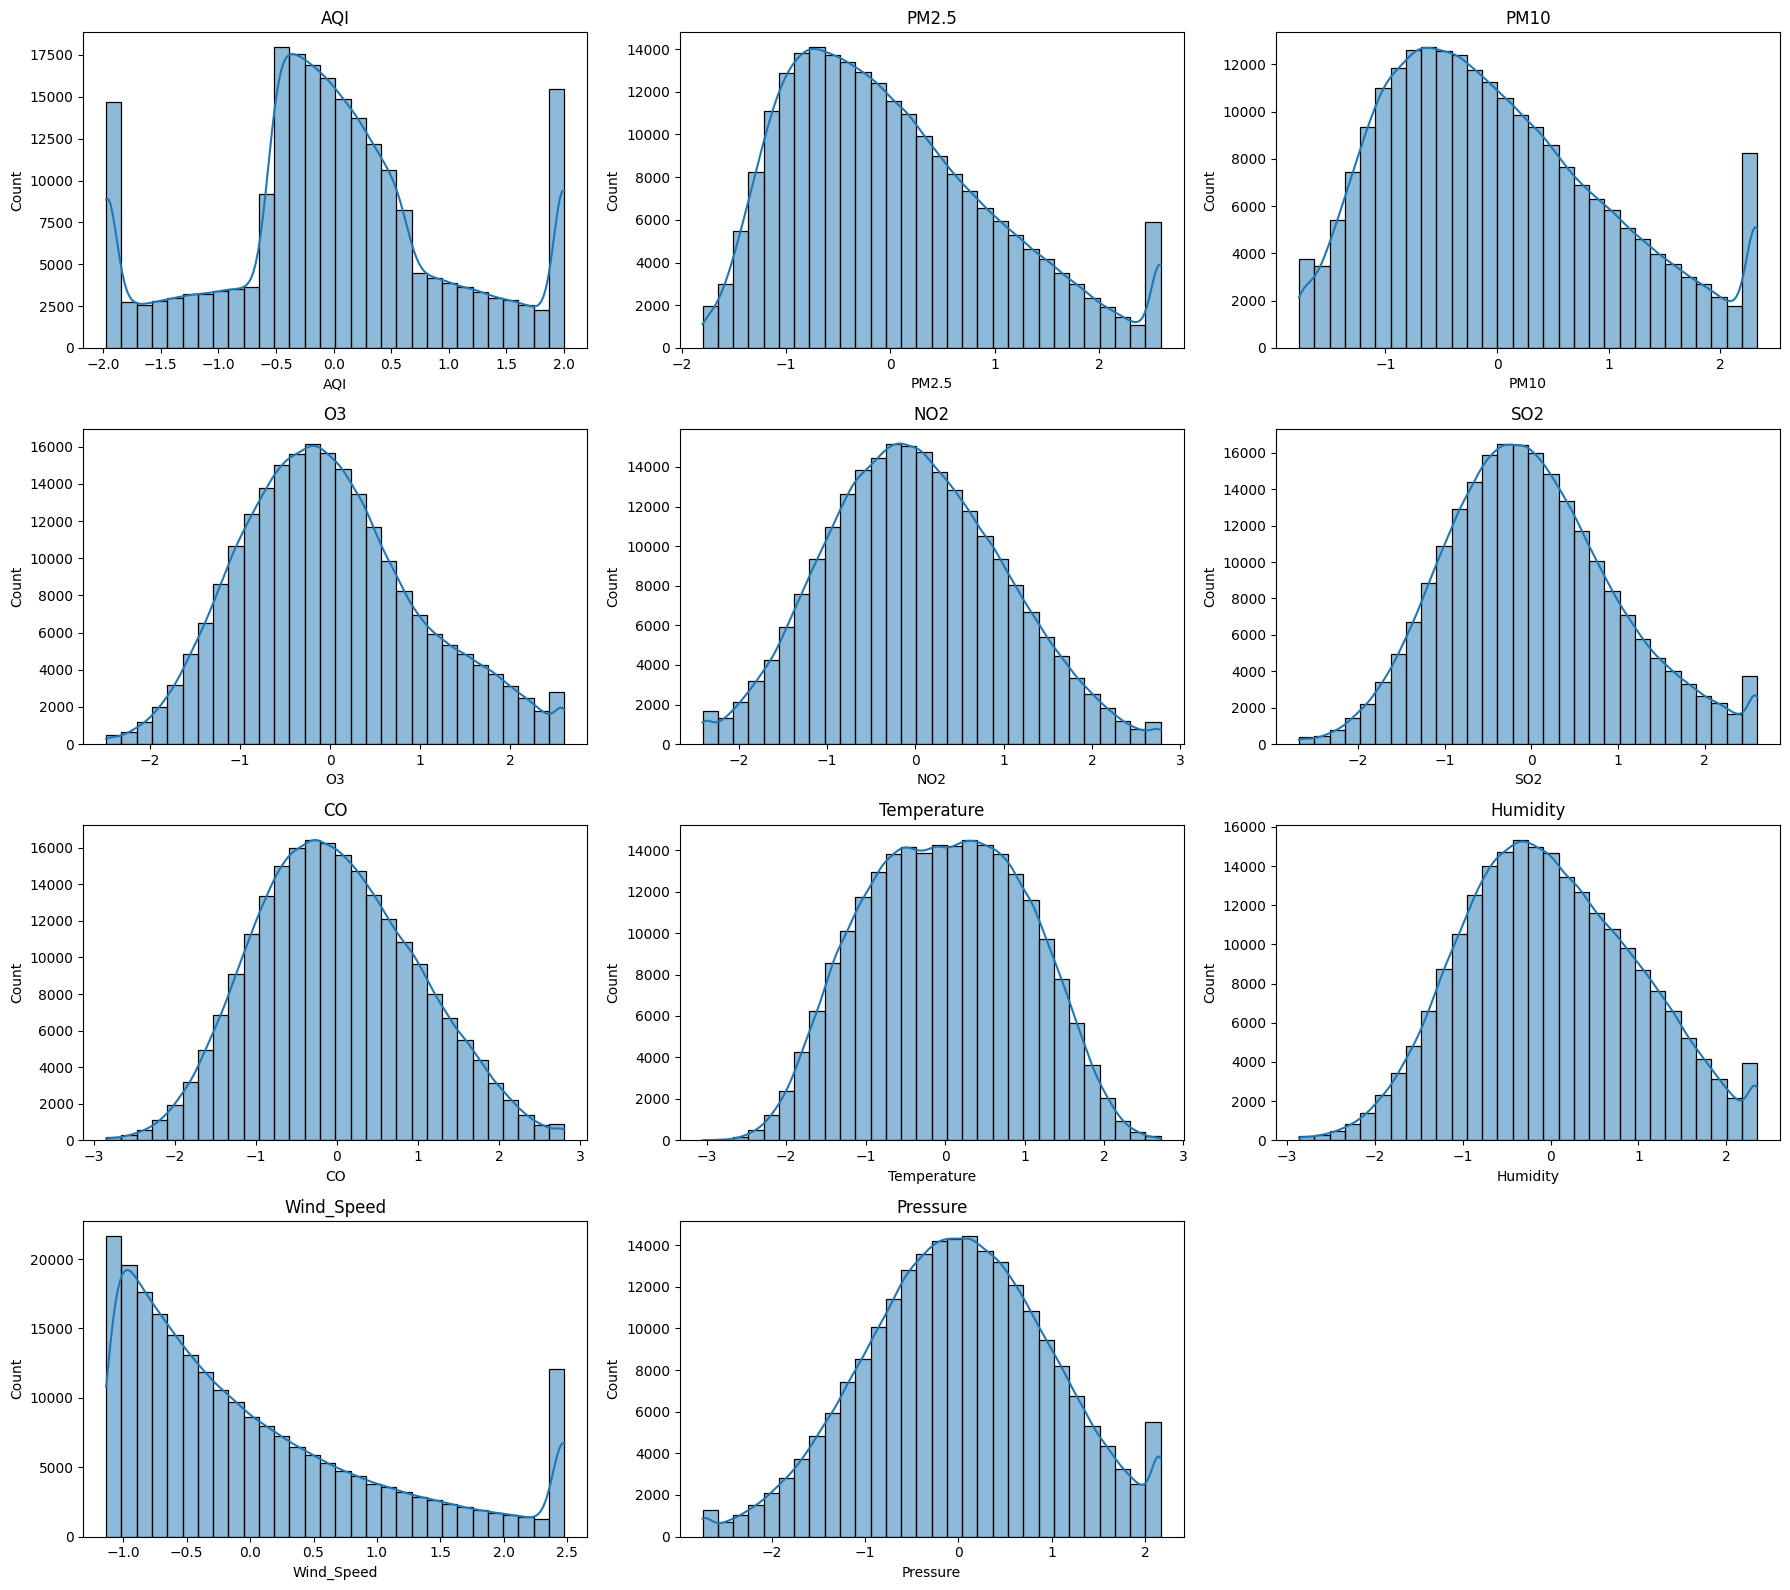

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numerical_features = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure']

n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    sns.histplot(
        data=df,
        x=feature,
        kde=True,
        bins=30,
        ax=axes[i]
    )
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These histograms display the distribution of the features in the Dhaka air quality dataset. The KDE (Kernel Density Estimation) curve overlays the histogram, providing a smoothed estimate of the data's probability density. This visualization highlights the central tendency, spread, and potential skewness of that feature, aiding in understanding its role in air quality analysis. For example, high peaks in AQI or PM2.5 indicate frequent pollution spikes.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

raw_df = pd.read_csv(
    "/root/.cache/kagglehub/datasets/shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset/versions/1/dhaka_air_quality_2000_2025.csv",
    parse_dates=['datetime']
)
# Taken 5% of the data as SubSample
df_sample = raw_df.sample(frac=0.05, random_state=42).sort_values('datetime')

df_sample.set_index('datetime', inplace = True)

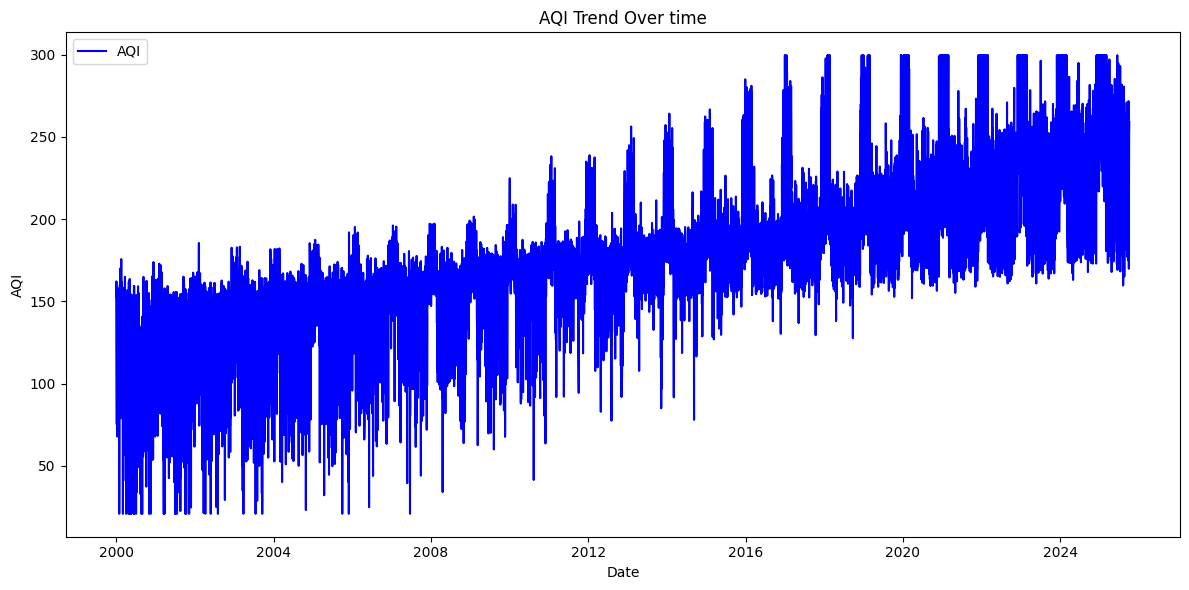

In [19]:
# AQI Trend over Time
plt.figure(figsize=(12,6))
plt.plot(df_sample.index, df_sample['AQI'], label= 'AQI', color = 'blue')
plt.title('AQI Trend Over time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()

Peaks in AQI indicate periods of poor air quality, potentially tied to seasonal or urban activity patterns.

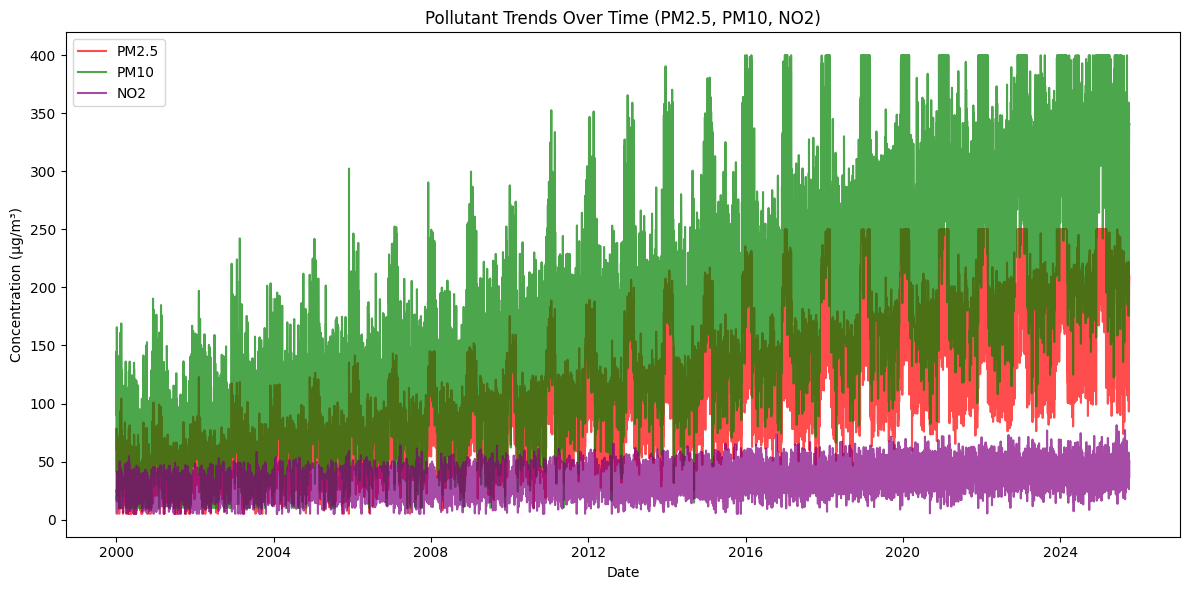

In [20]:
# Pollutant Trends Over Time
plt.figure(figsize=(12,6))
plt.plot(df_sample.index, df_sample['PM2.5'], label = 'PM2.5', color='red', alpha = 0.7)
plt.plot(df_sample.index, df_sample['PM10'], label='PM10', color='green', alpha=0.7)
plt.plot(df_sample.index, df_sample['NO2'], label='NO2', color='purple', alpha=0.7)
plt.title('Pollutant Trends Over Time (PM2.5, PM10, NO2)')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.tight_layout()
plt.show()

- PM10: Often directly emitted (primary) from mechanical processes like crushing and road dust.
- PM2.5: Frequently formed in the atmosphere (secondary) from gaseous precursors, making it more chemically complex, though directly emitted from combustion

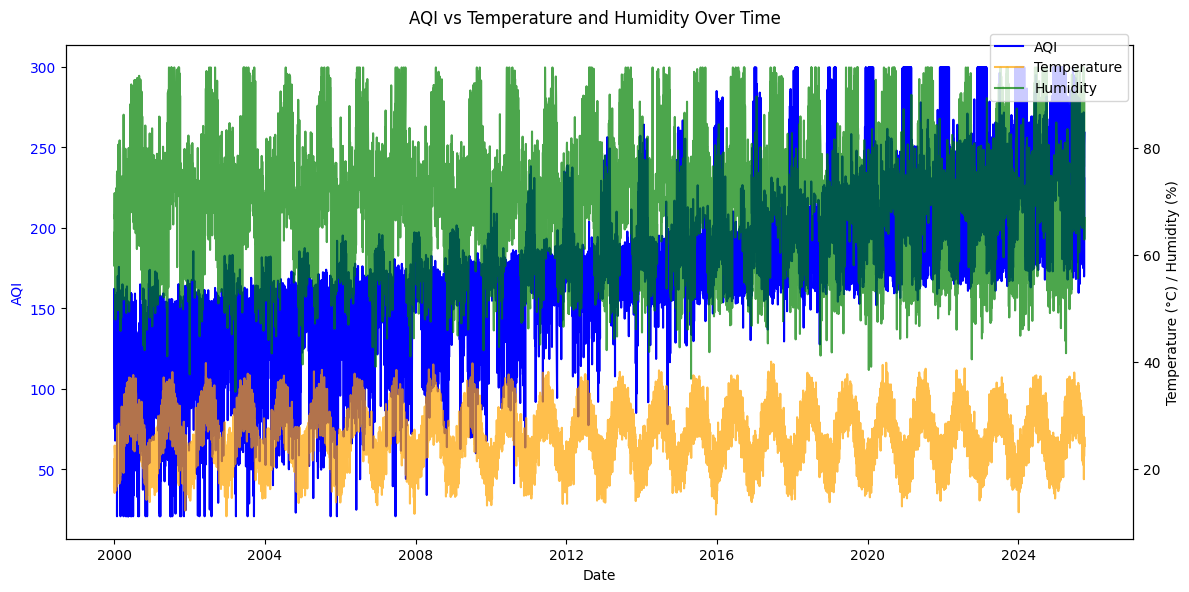

In [21]:
# Meteorological Variables vs AQI
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_sample.index, df_sample['AQI'], label='AQI', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('AQI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_sample.index, df_sample['Temperature'], label='Temperature', color='orange',alpha=0.7)
ax2.plot(df_sample.index, df_sample['Humidity'], label='Humidity', color='green', alpha=0.7)
ax2.set_ylabel('Temperature (°C) / Humidity (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
fig.suptitle('AQI vs Temperature and Humidity Over Time')
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()
plt.show()

AQI may correlate with meteorological factors, e.g., higher humidity potentially linked to lower AQI.

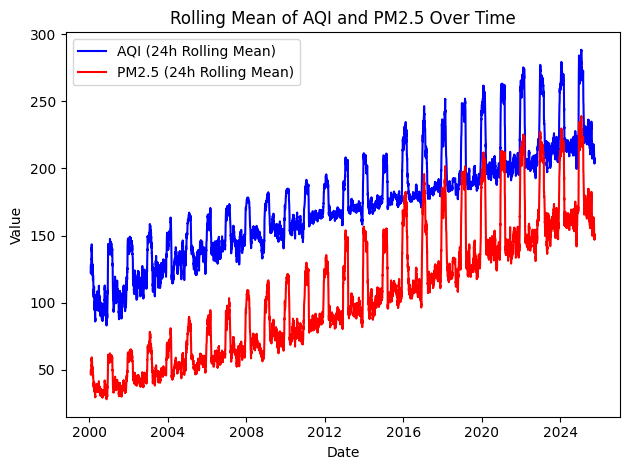

In [22]:
# Rolling Mean of AQI and PM2.5
plt.plot(df_sample.index, df_sample['AQI'].rolling(window=24).mean(), label='AQI (24h Rolling Mean)', color='blue')
plt.plot(df_sample.index, df_sample['PM2.5'].rolling(window=24).mean(), label='PM2.5 (24h Rolling Mean)', color='red')
plt.title('Rolling Mean of AQI and PM2.5 Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

Smoothed trends reveal seasonal patterns and confirm PM2.5 as a major driver of AQI.

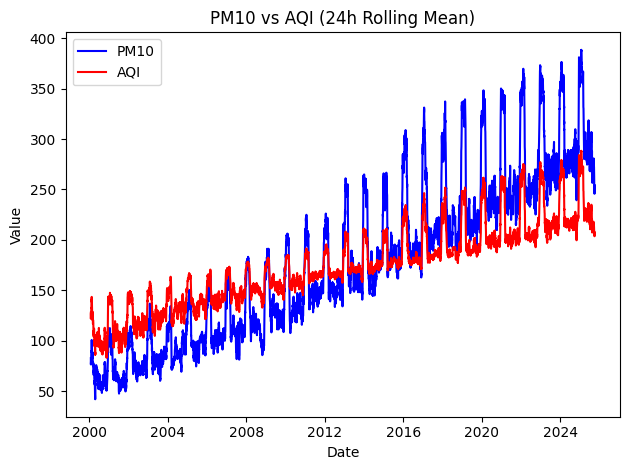

In [23]:
plt.plot(df_sample.index, df_sample['PM10'].rolling(24).mean(), label='PM10', color='blue')
plt.plot(df_sample.index, df_sample['AQI'].rolling(24).mean(), label='AQI', color='red')
plt.title('PM10 vs AQI (24h Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Clean column names
raw_df.columns = raw_df.columns.str.strip().str.replace('"', '')

# Replace '?' with NaN and drop missing values
raw_df.replace('?', np.nan, inplace=True)
raw_df.dropna(inplace=True)

# Convert datetime to datetime object
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

# Feature Engineering for Barplots
# Extract temporal features
raw_df['year'] = raw_df['datetime'].dt.year
raw_df['month'] = raw_df['datetime'].dt.month
raw_df['hour'] = raw_df['datetime'].dt.hour

# Create AQI categories
def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

raw_df['AQI_category'] = raw_df['AQI'].apply(categorize_aqi)

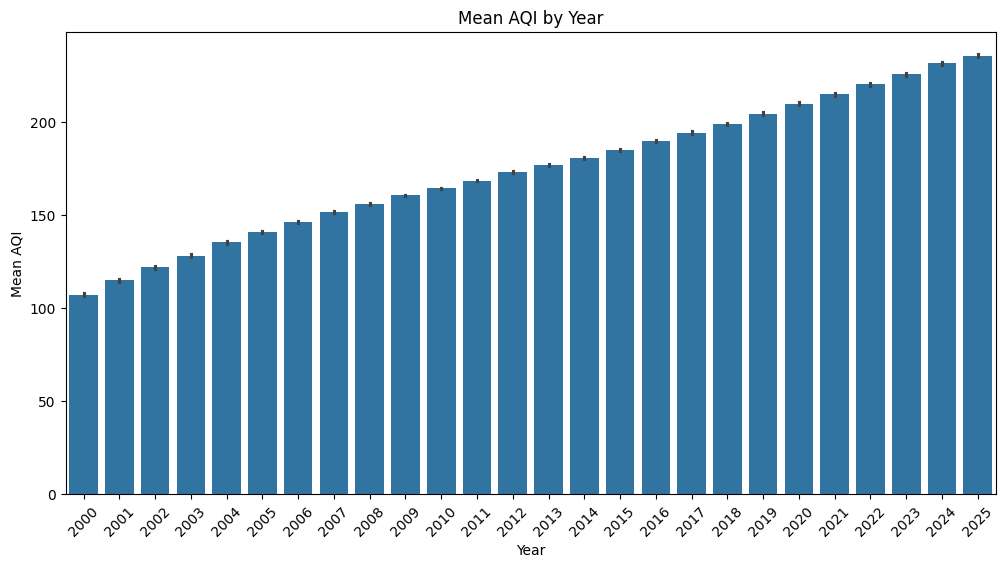

In [25]:
# Barplot 1: Mean AQI by Year
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='AQI', data=raw_df, estimator='mean')
plt.title('Mean AQI by Year')
plt.xlabel('Year')
plt.ylabel('Mean AQI')
plt.xticks(rotation=45)
plt.show()

This barplot shows the mean Air Quality Index (AQI) for each year from 2000 to 2025 in Dhaka. Higher bars indicate worse air quality, revealing long-term trends in pollution levels. This helps identify years with significant air quality changes, useful for policy analysis.

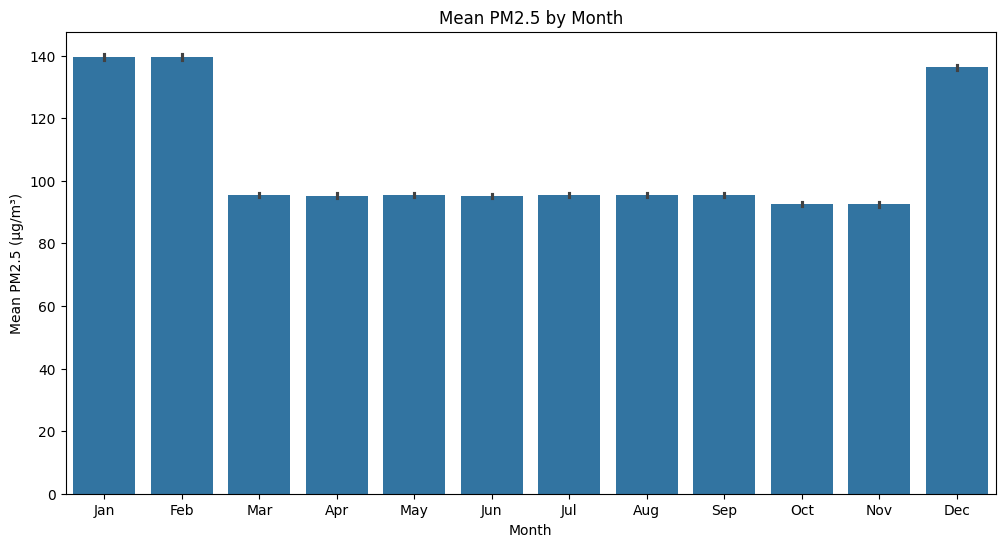

In [26]:
# Barplot 2: Mean PM2.5 by Month
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='PM2.5', data=raw_df, estimator='mean')
plt.title('Mean PM2.5 by Month')
plt.xlabel('Month')
plt.ylabel('Mean PM2.5 (µg/m³)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

This barplot displays the average PM2.5 concentration by month, highlighting seasonal variations in fine particulate matter. Peaks in certain months (e.g., winter months) suggest seasonal pollution patterns, critical for public health planning.

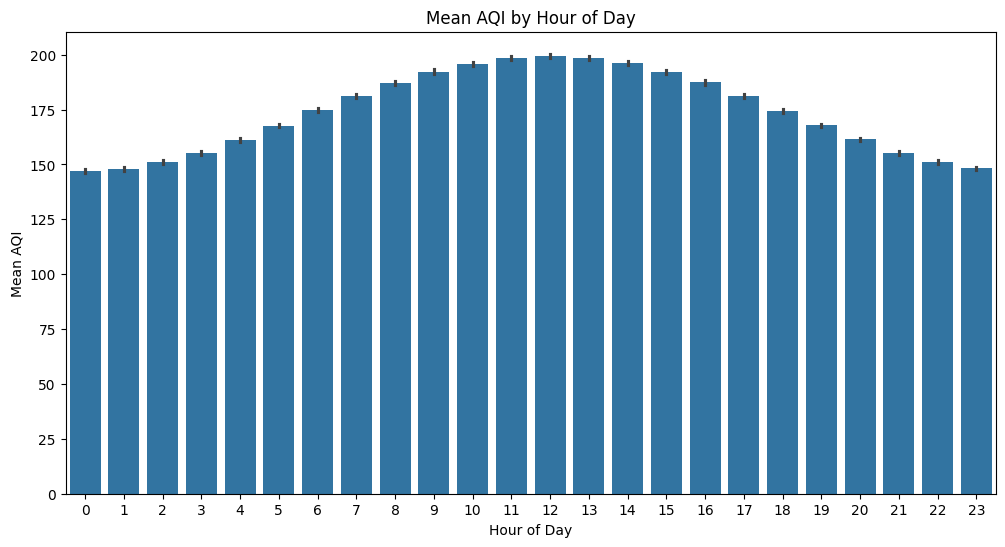

In [27]:
# Barplot 3: Mean AQI by Hour
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='AQI', data=raw_df, estimator='mean')
plt.title('Mean AQI by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean AQI')
plt.show()

This barplot illustrates the average AQI across different hours of the day. It reveals diurnal patterns in air quality, such as higher pollution during peak traffic or industrial activity hours (e.g. from 9 AM - 3 PM), aiding in targeted interventions.

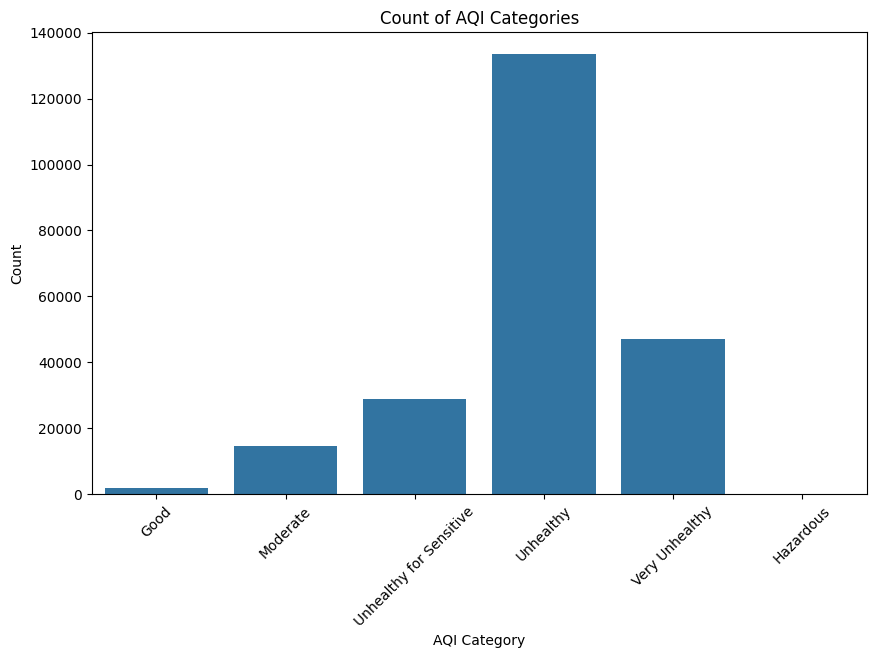

In [28]:
# Barplot 4: Count of AQI Categories
plt.figure(figsize=(10, 6))
sns.countplot(x='AQI_category', data=raw_df, order=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
plt.title('Count of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This barplot shows the frequency of different AQI categories in the dataset. It highlights the prevalence of air quality levels, such as how often Dhaka experiences 'Unhealthy' or 'Hazardous' conditions, crucial for assessing public health risks.

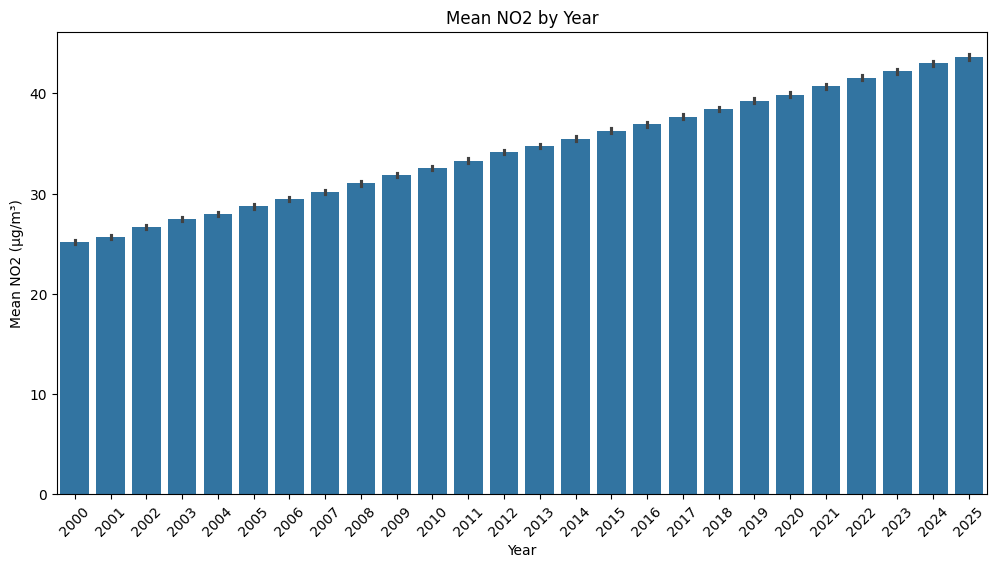

In [29]:
# Barplot 5: Mean NO2 by Year
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='NO2', data=raw_df, estimator='mean')
plt.title('Mean NO2 by Year')
plt.xlabel('Year')
plt.ylabel('Mean NO2 (µg/m³)')
plt.xticks(rotation=45)
plt.show()

This barplot displays the average NO2 (Nitrogen Dioxide) concentration directly proportionate to number of vehicles by year. It helps identify trends in NO2 pollution, often linked to vehicle emissions and industrial activities, informing emission control strategies.

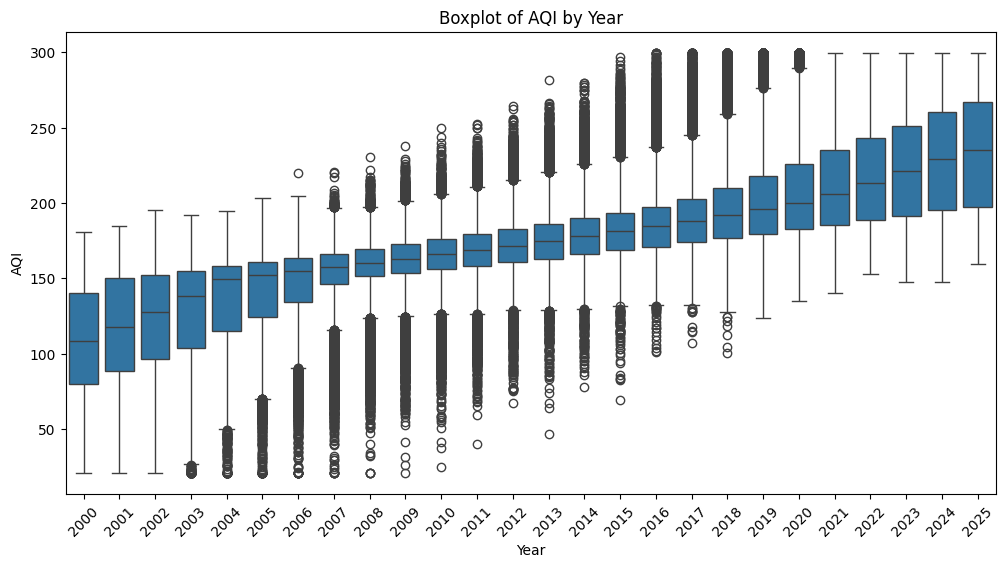

In [30]:
# Boxplot 1: AQI by Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='AQI', data=raw_df)
plt.title('Boxplot of AQI by Year')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.show()

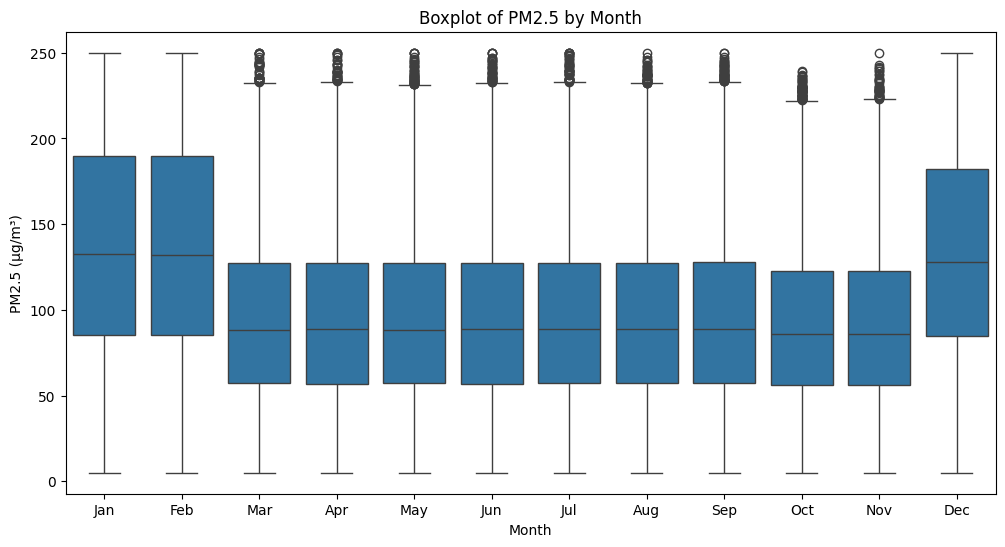

In [31]:
# Boxplot 2: PM2.5 by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='PM2.5', data=raw_df)
plt.title('Boxplot of PM2.5 by Month')
plt.xlabel('Month')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

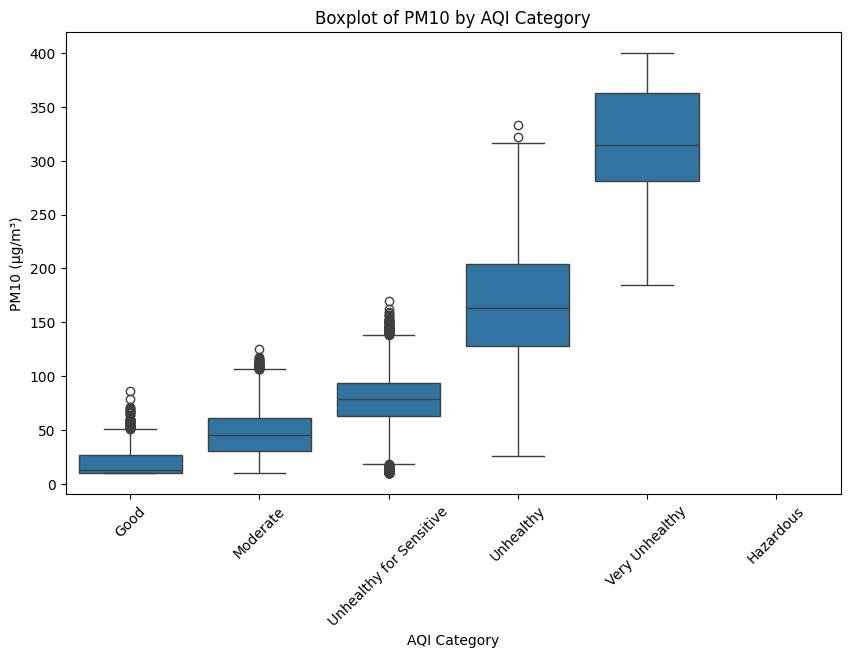

In [32]:
# Boxplot 3: PM10 by AQI Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='AQI_category', y='PM10', data=raw_df, order=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
plt.title('Boxplot of PM10 by AQI Category')
plt.xlabel('AQI Category')
plt.ylabel('PM10 (µg/m³)')
plt.xticks(rotation=45)
plt.show()

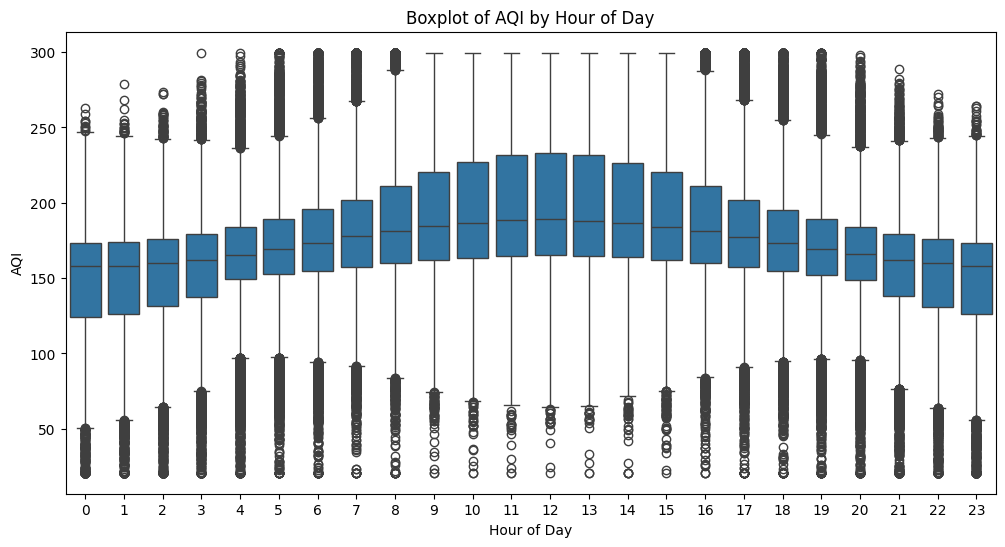

In [33]:
# Boxplot 4: AQI by Hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='AQI', data=raw_df)
plt.title('Boxplot of AQI by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('AQI')
plt.show()

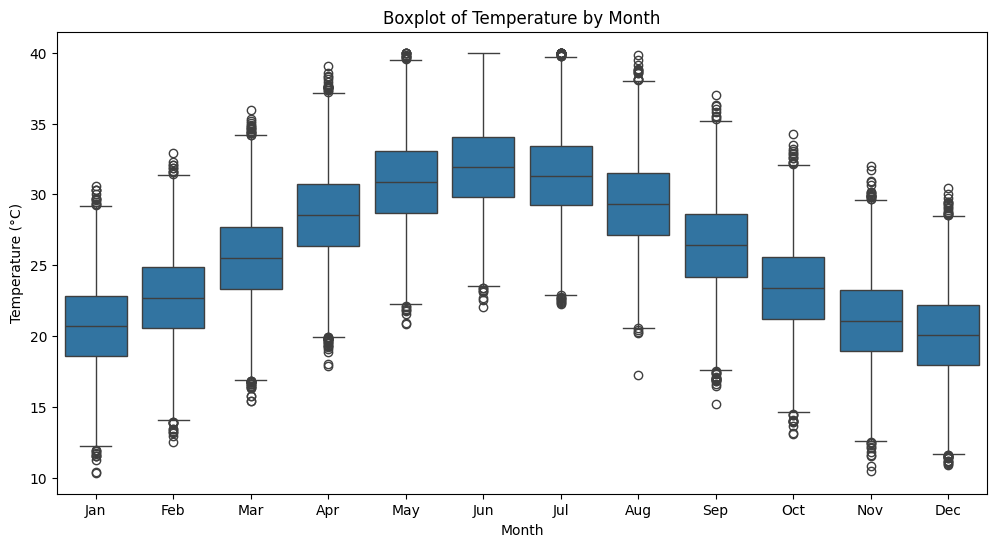

In [34]:
# Boxplot 5: Temperature by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Temperature', data=raw_df)
plt.title('Boxplot of Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### **Violin Plots**

In [35]:
raw_df['season'] = raw_df['month'].map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
                                6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon', 9: 'Autumn', 10: 'Autumn',
                                11: 'Autumn', 12: 'Winter'})

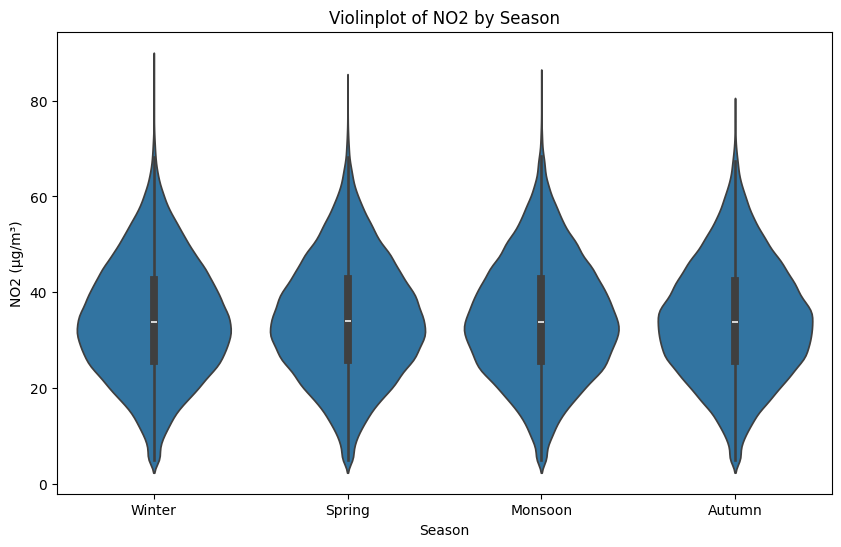

In [36]:
# Violinplot 1: NO2 by Season
plt.figure(figsize=(10, 6))
sns.violinplot(x='season', y='NO2', data=raw_df, order=['Winter', 'Spring', 'Monsoon', 'Autumn'])
plt.title('Violinplot of NO2 by Season')
plt.xlabel('Season')
plt.ylabel('NO2 (µg/m³)')
plt.show()

It is more-on-less constant

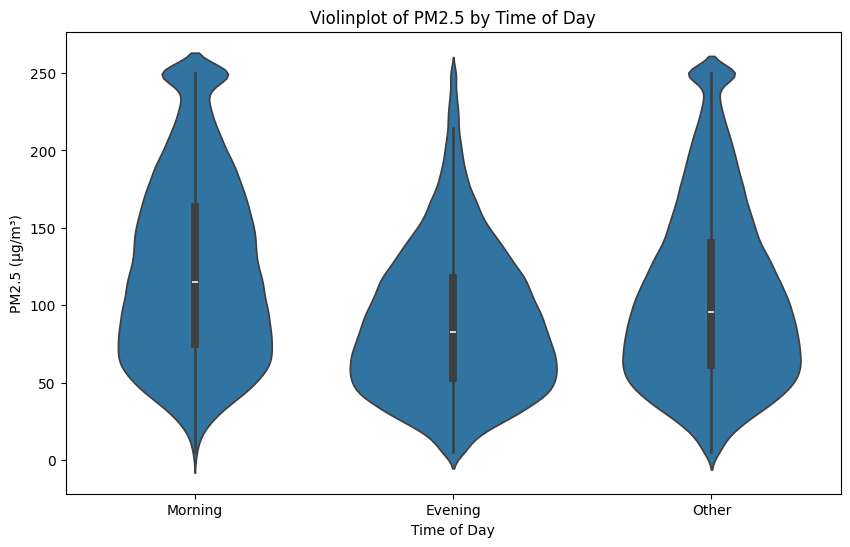

In [37]:
# Violinplot 2: PM2.5 by Hour (Morning vs. Evening)
raw_df['time_of_day'] = raw_df['hour'].apply(lambda x: 'Morning' if 6 <= x < 12 else 'Evening' if 18 <= x < 24 else 'Other')
plt.figure(figsize=(10, 6))
sns.violinplot(x='time_of_day', y='PM2.5', data=raw_df, order=['Morning', 'Evening', 'Other'])
plt.title('Violinplot of PM2.5 by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()

The amount of particulate matter (PM2.5) is often higher in the evening due to a combination of peak human activity (evening rush hour) and specific meteorological conditions that trap pollutants near the ground

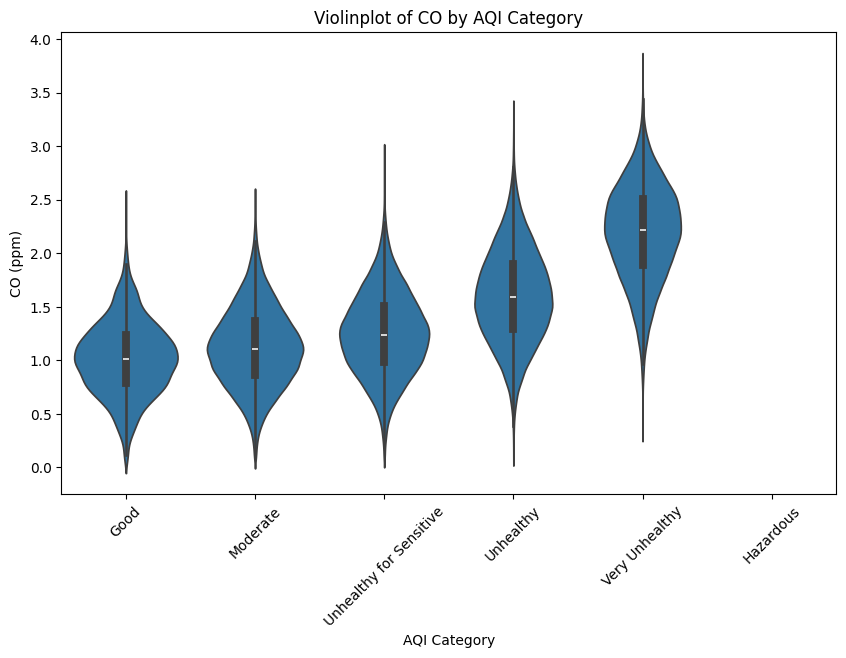

In [38]:
# Violinplot 3: CO by AQI Category
plt.figure(figsize=(10, 6))
sns.violinplot(x='AQI_category', y='CO', data=raw_df, order=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
plt.title('Violinplot of CO by AQI Category')
plt.xlabel('AQI Category')
plt.ylabel('CO (ppm)')
plt.xticks(rotation=45)
plt.show()

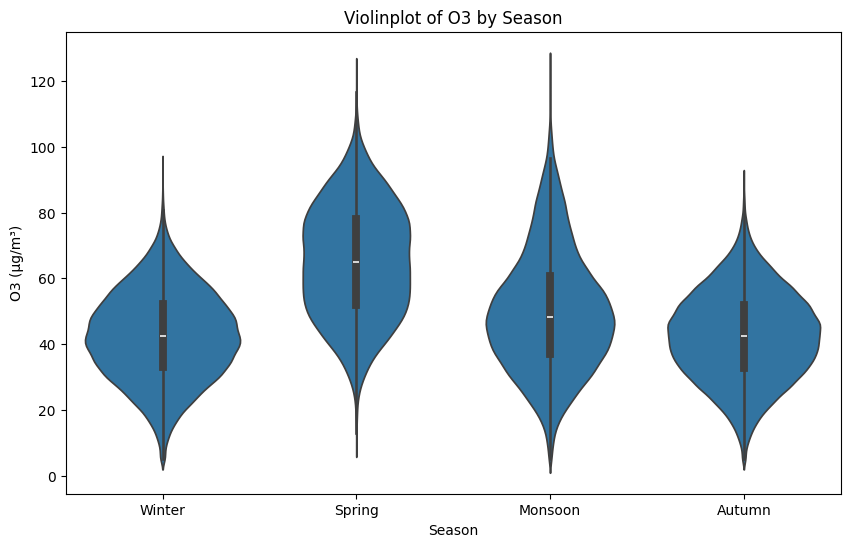

In [39]:
# Violinplot 4: O3 by Season
plt.figure(figsize=(10, 6))
sns.violinplot(x='season', y='O3', data=raw_df, order=['Winter', 'Spring', 'Monsoon', 'Autumn'])
plt.title('Violinplot of O3 by Season')
plt.xlabel('Season')
plt.ylabel('O3 (µg/m³)')
plt.show()

The shape and spread reveal seasonal ozone patterns, with potential peaks in spring due to photochemical reactions, and more condesation at winter and Autumn.

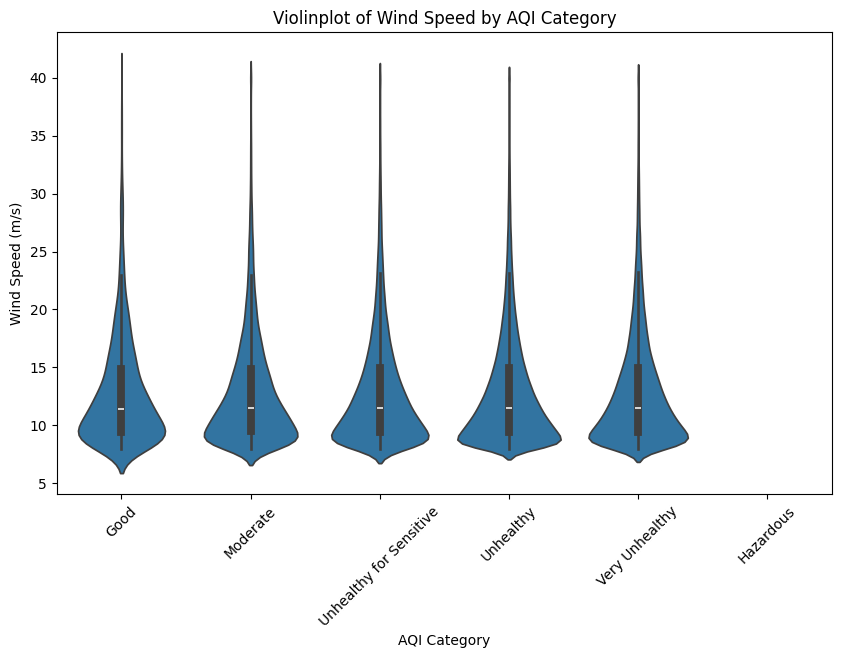

In [40]:
# Violinplot 5: Wind Speed by AQI Category
plt.figure(figsize=(10, 6))
sns.violinplot(x='AQI_category', y='Wind_Speed', data=raw_df, order=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
plt.title('Violinplot of Wind Speed by AQI Category')
plt.xlabel('AQI Category')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.show()

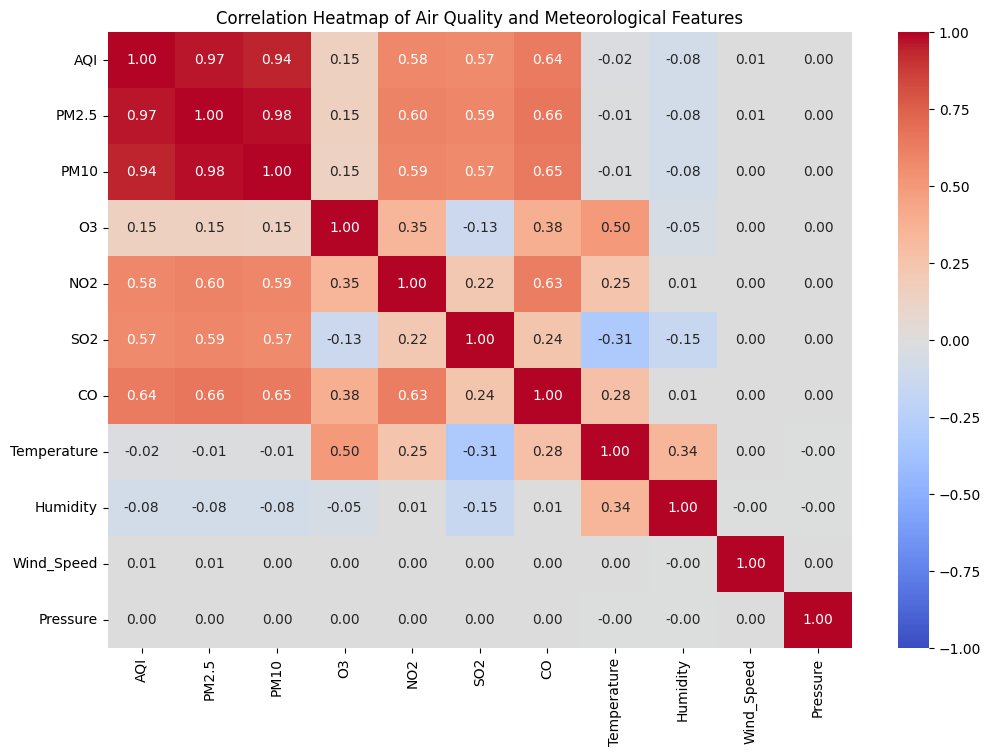

In [41]:
numerical_features = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure']

# Calculate correlation matrix
correlation_matrix = raw_df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Air Quality and Meteorological Features')
plt.show()

strong positive correlations between AQI and PM2.5/PM10 suggest these pollutants drive air quality degradation, while negative correlations with Wind_Speed may indicate dispersion of pollutants.

### **KDE plots**

In [42]:
def get_aqi_category(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Add AQI_Category column as the target for coloring
raw_df['AQI_Category'] = raw_df['AQI'].apply(get_aqi_category)
pollutant_cols = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'AQI', 'AQI_Category']
meteo_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'Pressure', 'AQI_Category']

<Figure size 640x480 with 0 Axes>

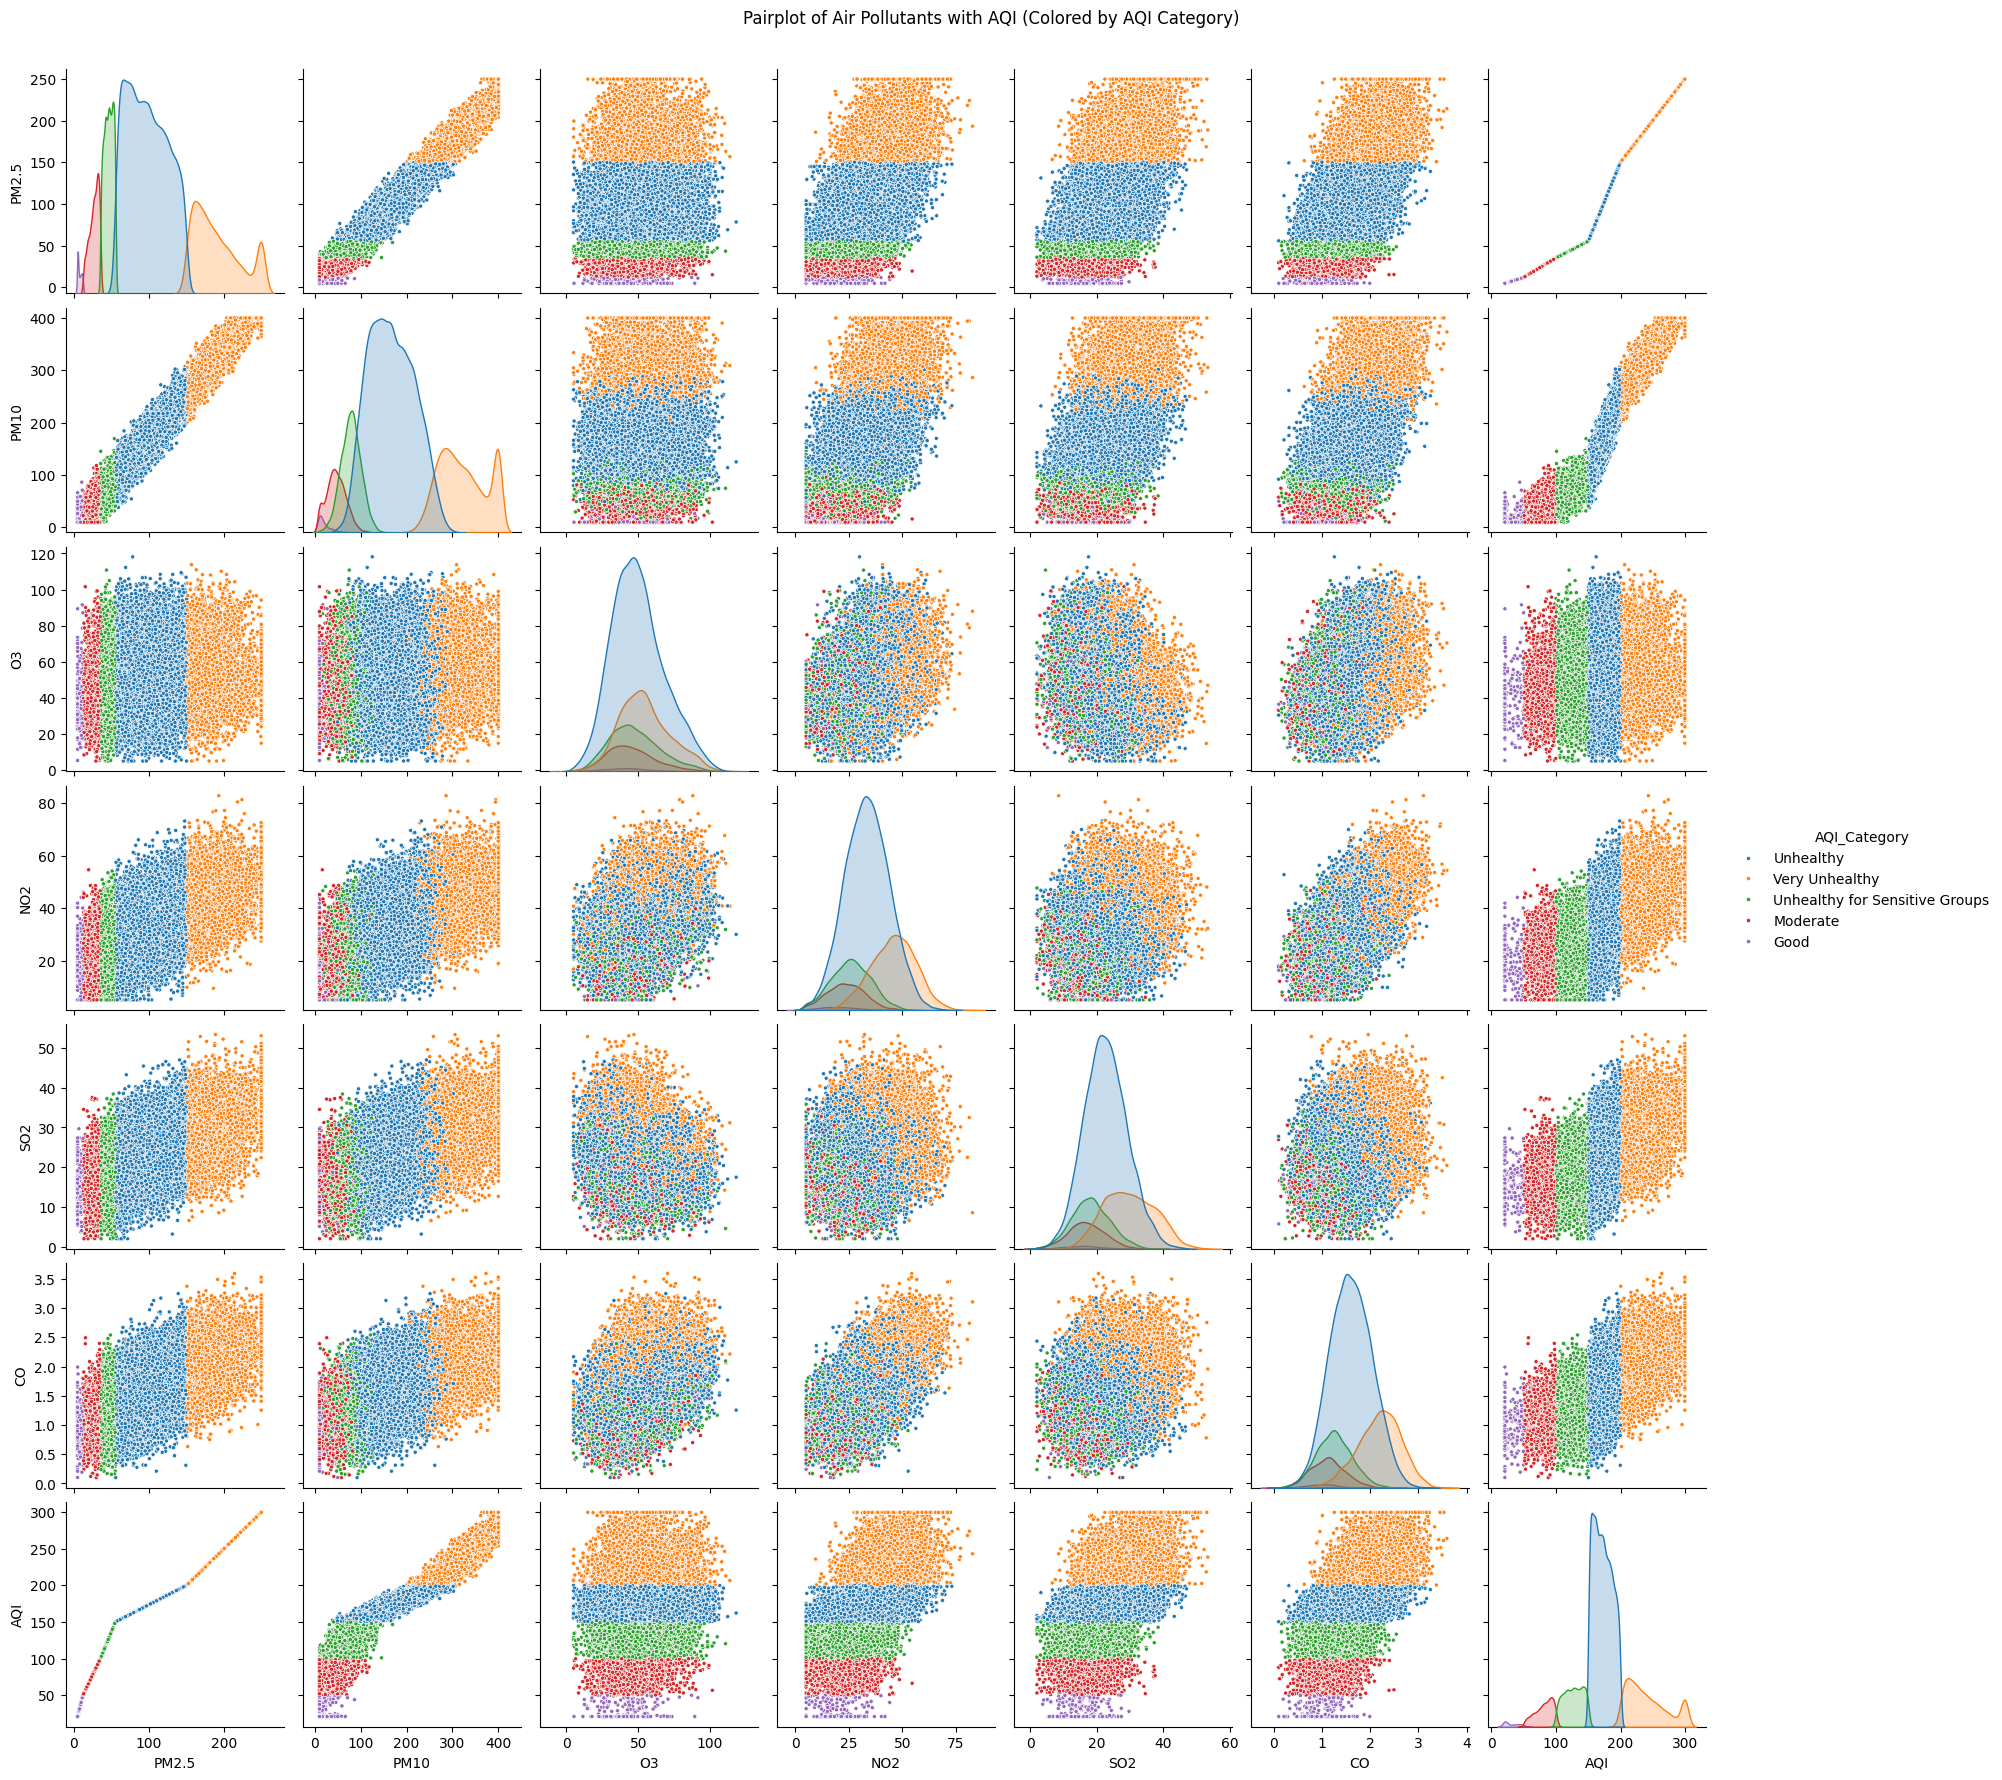

In [43]:
raw_df_sample = raw_df.sample(frac=0.1, random_state=42)

# Relationships between pollutant columns
plt.figure()
sns.pairplot(raw_df_sample[pollutant_cols], hue='AQI_Category', diag_kind='kde', markers='.')
plt.suptitle('Pairplot of Air Pollutants with AQI (Colored by AQI Category)', y=1.02)
plt.show()

<Figure size 640x480 with 0 Axes>

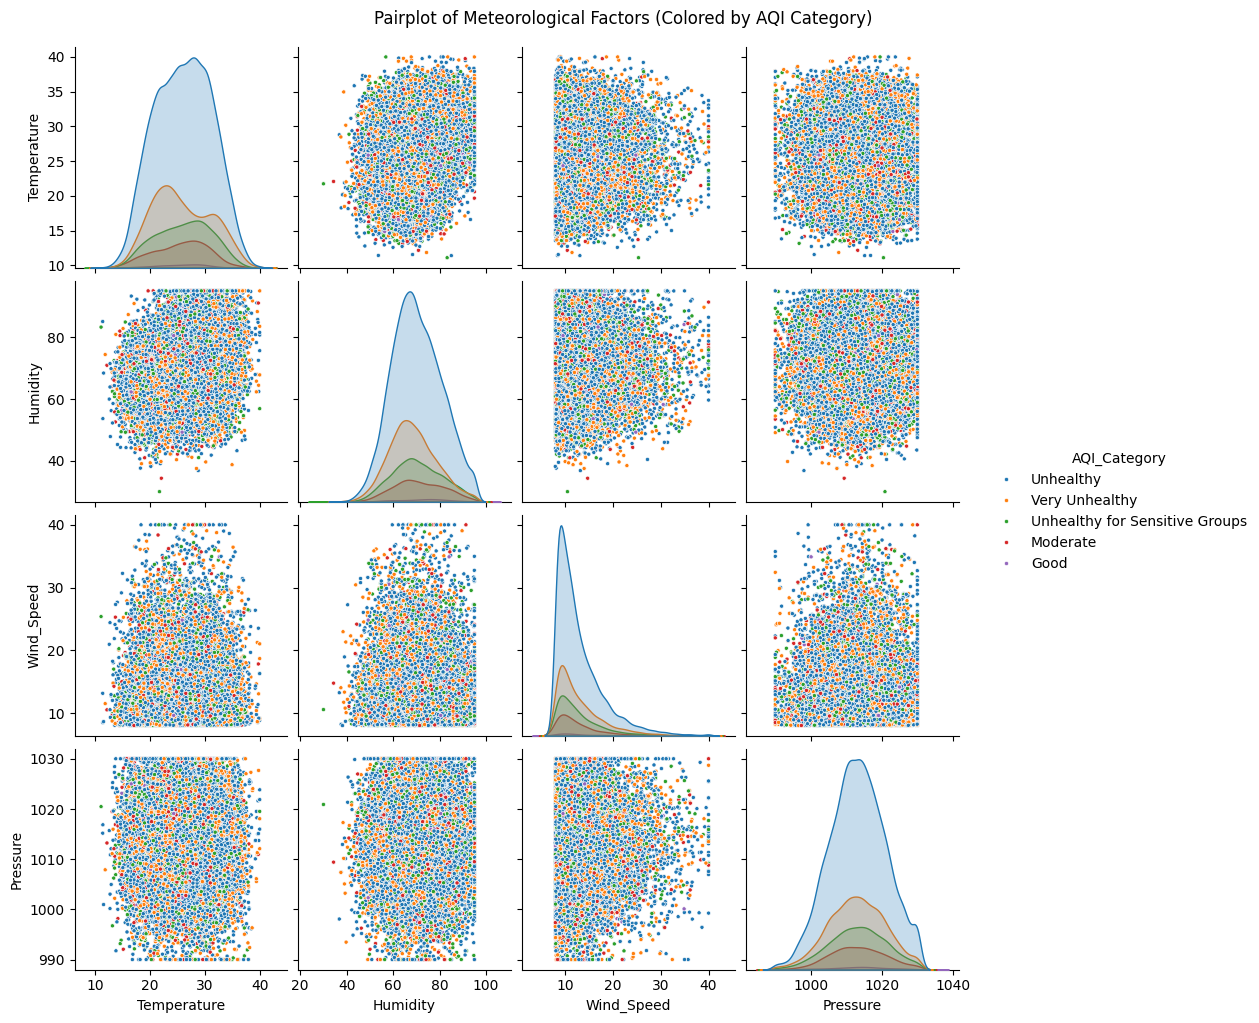

In [44]:
plt.figure()
sns.pairplot(raw_df_sample[meteo_cols], hue='AQI_Category', diag_kind='kde', markers='.')
plt.suptitle('Pairplot of Meteorological Factors (Colored by AQI Category)', y=1.02)
plt.show()

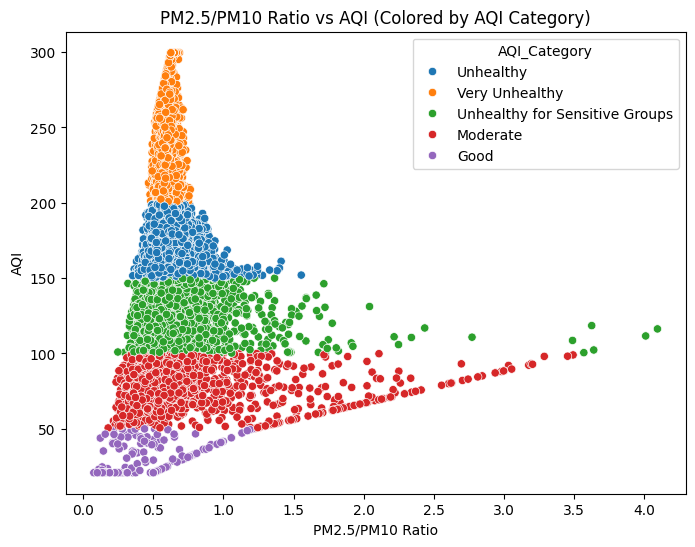

In [45]:
# 2. Pollutant Ratios
raw_df_sample['PM2.5_PM10_Ratio'] = raw_df_sample['PM2.5'] / raw_df_sample['PM10'].replace(0, np.nan)  # Avoid division by zero
raw_df_sample['NO2_SO2_Ratio'] = raw_df_sample['NO2'] / raw_df_sample['SO2'].replace(0, np.nan)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PM2.5_PM10_Ratio', y='AQI', hue='AQI_Category', data=raw_df_sample)
plt.title('PM2.5/PM10 Ratio vs AQI (Colored by AQI Category)')
plt.xlabel('PM2.5/PM10 Ratio')
plt.ylabel('AQI')
plt.show()

## **Model Training**

In [46]:
import pandas as pd
df = pd.read_csv(
    "/root/.cache/kagglehub/datasets/shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset/versions/1/dhaka_air_quality_2000_2025.csv"
)
df.head(2)

datetime         AQI      PM2.5       PM10         O3  \
0  2000-01-01 00:00:00  121.861086  44.200712  93.224101  20.586862   
1  2000-01-01 01:00:00   99.598077  35.212704  78.893066  22.429471   

         NO2        SO2        CO  Temperature   Humidity  Wind_Speed  \
0  15.391414  28.219932  1.049477    20.956667  71.272569    8.375675   
1  26.824534  24.385188  0.943859    13.761031  42.616871   10.880553   

      Pressure  
0  1011.742574  
1  1010.949986

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225816 entries, 0 to 225815
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     225816 non-null  object 
 1   AQI          225816 non-null  float64
 2   PM2.5        225816 non-null  float64
 3   PM10         225816 non-null  float64
 4   O3           225816 non-null  float64
 5   NO2          225816 non-null  float64
 6   SO2          225816 non-null  float64
 7   CO           225816 non-null  float64
 8   Temperature  225816 non-null  float64
 9   Humidity     225816 non-null  float64
 10  Wind_Speed   225816 non-null  float64
 11  Pressure     225816 non-null  float64
dtypes: float64(11), object(1)
memory usage: 20.7+ MB


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [49]:
# Feature Engineering (consistent with previous steps)
df['datetime'] = pd.to_datetime(df['datetime'])

df['Hour'] = df['datetime'].dt.hour
df['DayOfWeek'] = df['datetime'].dt.dayofweek
df['Month'] = df['datetime'].dt.month
df['Year'] = df['datetime'].dt.year
df['PM2.5_PM10_Ratio'] = df['PM2.5'] / df['PM10'].replace(0, np.nan)
df['NO2_SO2_Ratio'] = df['NO2'] / df['SO2'].replace(0, np.nan)
df['AQI_Lag1'] = df['AQI'].shift(1).fillna(0)

# Drop NaN values
df = df.dropna()

In [50]:
# Select features and target
features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure',
            'Hour', 'DayOfWeek', 'Month', 'Year', 'PM2.5_PM10_Ratio', 'NO2_SO2_Ratio', 'AQI_Lag1']
X = df[features]
y = df['AQI']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [51]:
# Define optimized models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_jobs=-1, random_state=42),
    'XGBoost': XGBRegressor(eval_metric='rmse', random_state=42),
    'MLP Neural Network': MLPRegressor(random_state=42)
}

In [52]:
# Train and evaluate models
results = {}
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


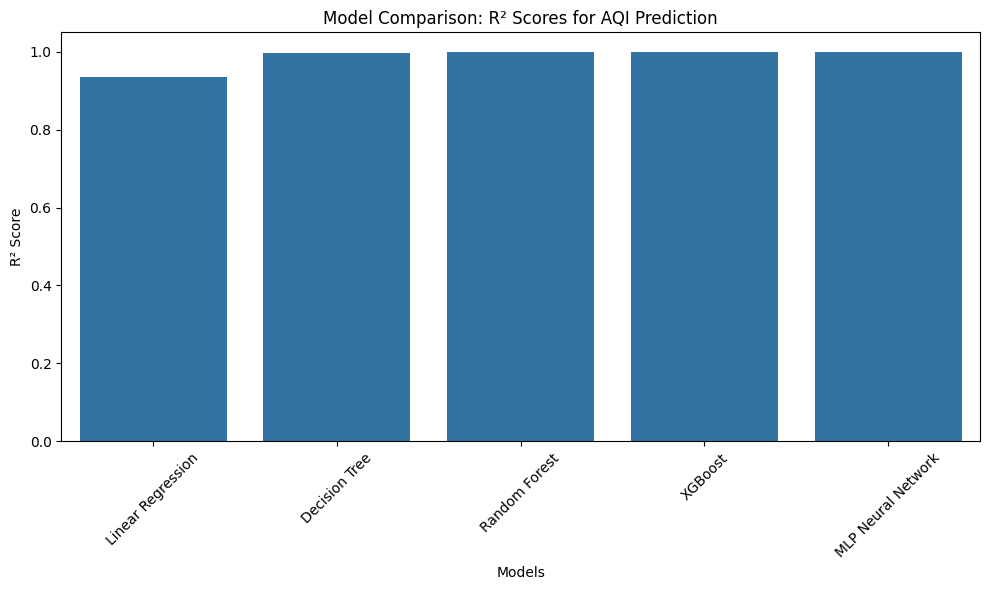

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[res['R2'] for res in results.values()])
plt.title('Model Comparison: R² Scores for AQI Prediction')
plt.ylabel('R² Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
print("Model Evaluation Results:")
for name, res in results.items():
    print(f"{name}: MSE = {res['MSE']:.2f}, R2 = {res['R2']:.2f}")

Model Evaluation Results:
Linear Regression: MSE = 148.12, R2 = 0.94
Decision Tree: MSE = 5.15, R2 = 1.00
Random Forest: MSE = 0.00, R2 = 1.00
XGBoost: MSE = 0.31, R2 = 1.00
MLP Neural Network: MSE = 0.04, R2 = 1.00


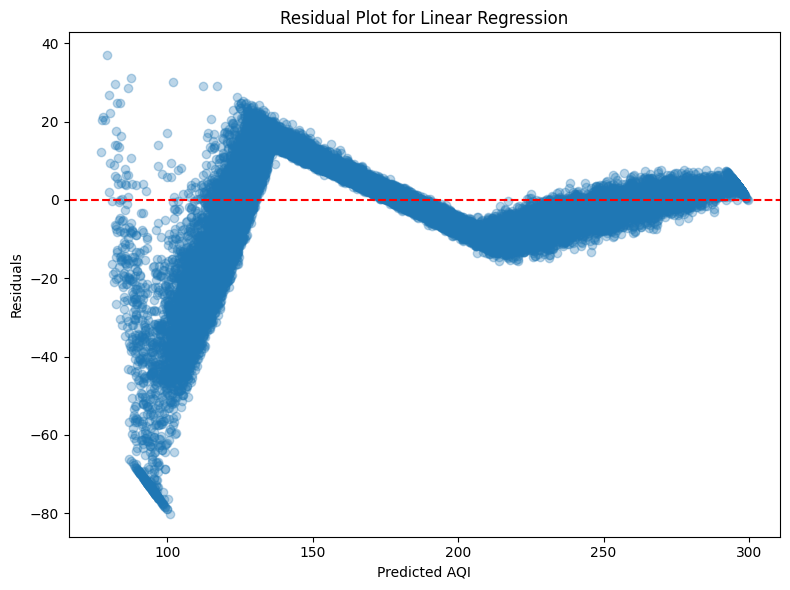

In [55]:
lr_model = models['Linear Regression']
y_pred_lr = lr_model.predict(X_test)
residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

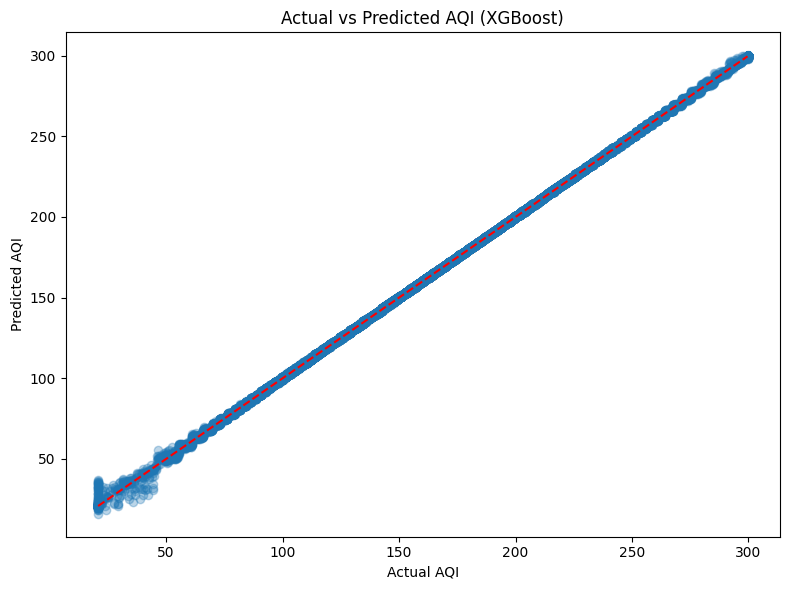

In [56]:
xgb_model = models['XGBoost']
y_pred_xgb = xgb_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted AQI (XGBoost)')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.tight_layout()
plt.show()

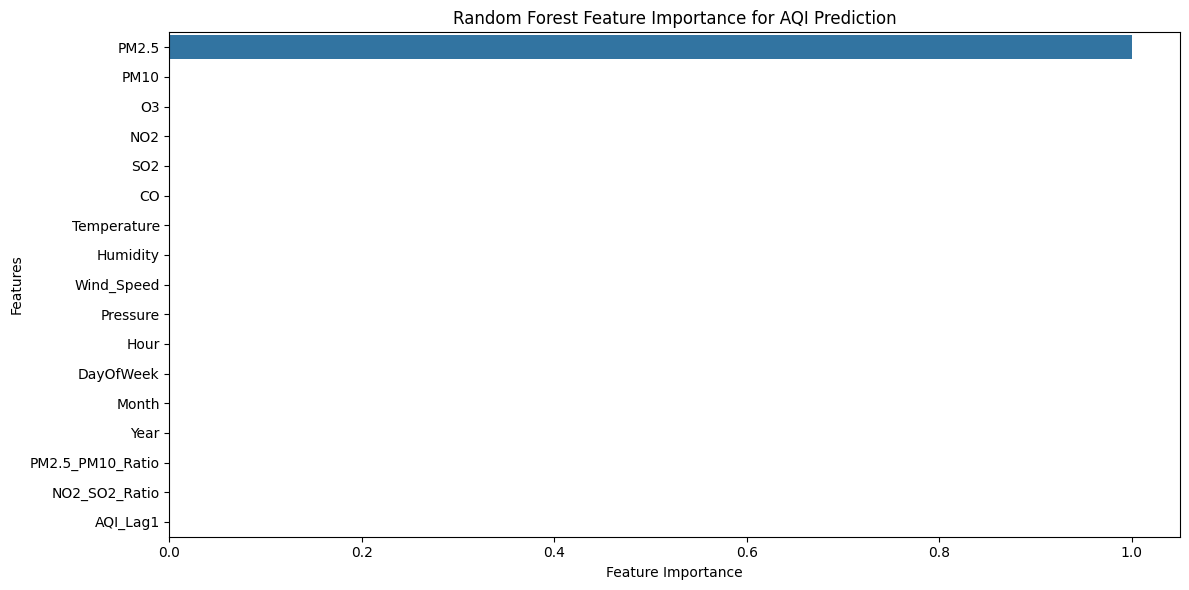

In [57]:
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=features)
plt.title('Random Forest Feature Importance for AQI Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

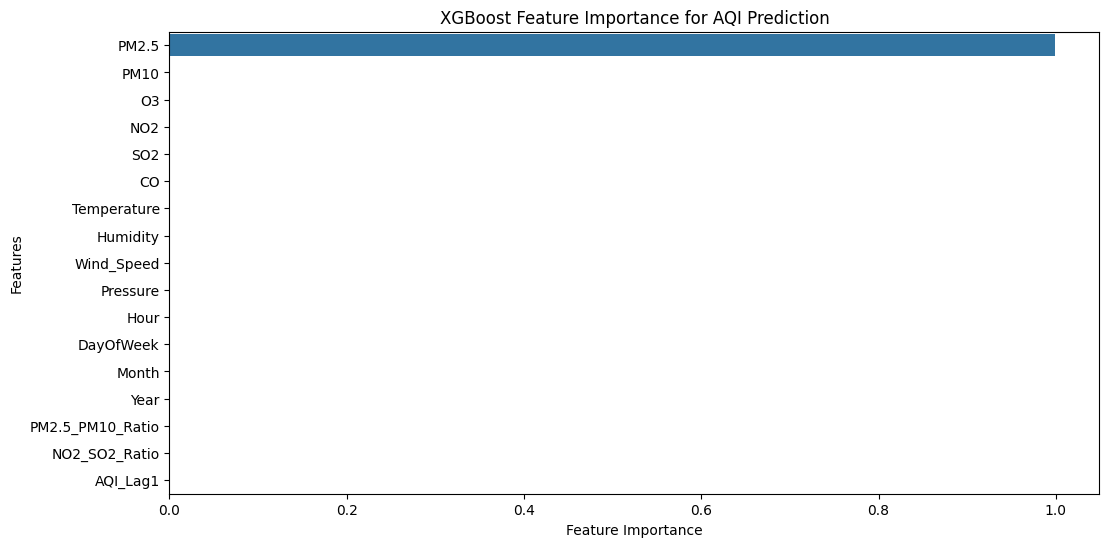

In [58]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
importances_xgb = xgb_model.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=importances_xgb, y=features)
plt.title('XGBoost Feature Importance for AQI Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

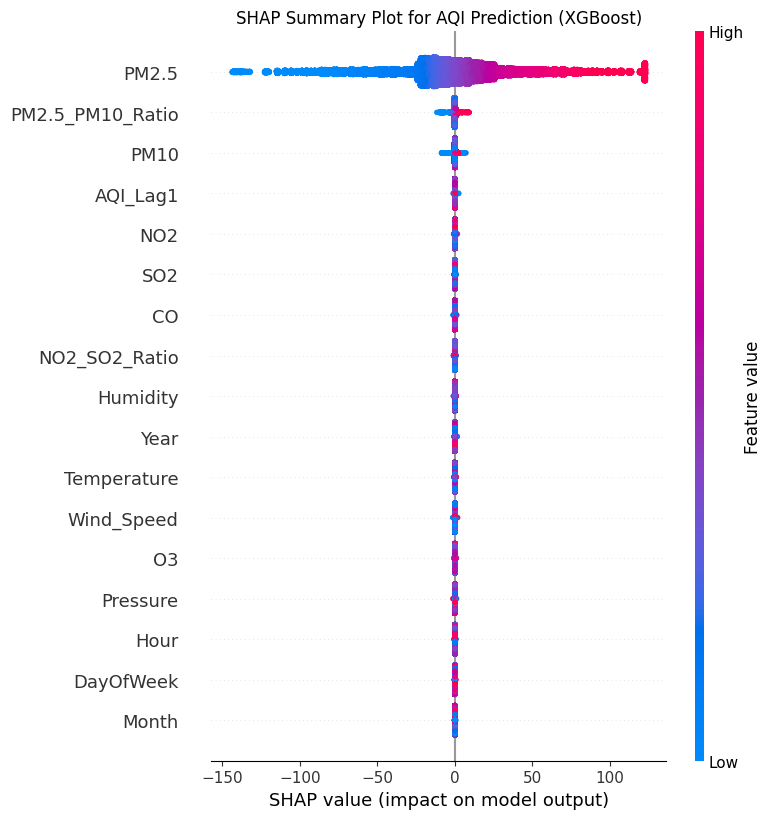

In [59]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title('SHAP Summary Plot for AQI Prediction (XGBoost)')
plt.tight_layout()
plt.show()

In [60]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [65]:
def predict_(data, model):
  input_dict = data.dict()

  # Parse datetime string and extract temporal features
  dt_object = datetime.fromisoformat(input_dict.pop('datetime_str'))
  input_dict['Hour'] = dt_object.hour
  input_dict['DayOfWeek'] = dt_object.weekday() # Monday=0, Sunday=6
  input_dict['Month'] = dt_object.month
  input_dict['Year'] = dt_object.year

  # Calculate derived ratio features
  input_dict['PM2_5_PM10_Ratio'] = input_dict['PM2_5'] / (input_dict['PM10'] + 1e-6)
  input_dict['NO2_SO2_Ratio'] = input_dict['NO2'] / (input_dict['SO2'] + 1e-6)

  # The order of features needs to match the training data
  features_order = [
      'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure',
      'Hour', 'DayOfWeek', 'Month', 'Year', 'PM2.5_PM10_Ratio', 'NO2_SO2_Ratio', 'AQI_Lag1'
  ]

  # Create a DataFrame from the processed input dictionary
  processed_input_data = {
      'PM2.5': input_dict['PM2_5'],
      'PM10': input_dict['PM10'],
      'O3': input_dict['O3'],
      'NO2': input_dict['NO2'],
      'SO2': input_dict['SO2'],
      'CO': input_dict['CO'],
      'Temperature': input_dict['Temperature'],
      'Humidity': input_dict['Humidity'],
      'Wind_Speed': input_dict['Wind_Speed'],
      'Pressure': input_dict['Pressure'],
      'Hour': input_dict['Hour'],
      'DayOfWeek': input_dict['DayOfWeek'],
      'Month': input_dict['Month'],
      'Year': input_dict['Year'],
      'PM2.5_PM10_Ratio': input_dict['PM2_5_PM10_Ratio'],
      'NO2_SO2_Ratio': input_dict['NO2_SO2_Ratio'],
      'AQI_Lag1': input_dict['AQI_Lag1']
  }

  input_df = pd.DataFrame([processed_input_data], columns=features_order)

  # Scale the input data
  scaled_input = scaler.transform(input_df)

  # Make prediction
  prediction = model.predict(scaled_input)[0]

  return {"predicted_aqi": prediction.item()}

In [71]:
import pandas as pd
from pydantic import BaseModel
from datetime import datetime
import numpy as np

# Define the input data model using Pydantic
class AQIInput(BaseModel):
    datetime_str: str
    PM2_5: float
    PM10: float
    O3: float
    NO2: float
    SO2: float
    CO: float
    Temperature: float
    Humidity: float
    Wind_Speed: float
    Pressure: float
    AQI_Lag1: float

# Define the predict_ function
def predict_(data, model):
  input_dict = data.model_dump()

  # Parse datetime string and extract temporal features
  dt_object = datetime.fromisoformat(input_dict.pop('datetime_str'))
  input_dict['Hour'] = dt_object.hour
  input_dict['DayOfWeek'] = dt_object.weekday() # Monday=0, Sunday=6
  input_dict['Month'] = dt_object.month
  input_dict['Year'] = dt_object.year

  # Calculate derived ratio features
  input_dict['PM2_5_PM10_Ratio'] = input_dict['PM2_5'] / (input_dict['PM10'] + 1e-6)
  input_dict['NO2_SO2_Ratio'] = input_dict['NO2'] / (input_dict['SO2'] + 1e-6)

  # The order of features needs to match the training data
  features_order = [
      'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure',
      'Hour', 'DayOfWeek', 'Month', 'Year', 'PM2.5_PM10_Ratio', 'NO2_SO2_Ratio', 'AQI_Lag1'
  ]

  # Create a DataFrame from the processed input dictionary
  processed_input_data = {
      'PM2.5': input_dict['PM2_5'],
      'PM10': input_dict['PM10'],
      'O3': input_dict['O3'],
      'NO2': input_dict['NO2'],
      'SO2': input_dict['SO2'],
      'CO': input_dict['CO'],
      'Temperature': input_dict['Temperature'],
      'Humidity': input_dict['Humidity'],
      'Wind_Speed': input_dict['Wind_Speed'],
      'Pressure': input_dict['Pressure'],
      'Hour': input_dict['Hour'],
      'DayOfWeek': input_dict['DayOfWeek'],
      'Month': input_dict['Month'],
      'Year': input_dict['Year'],
      'PM2.5_PM10_Ratio': input_dict['PM2_5_PM10_Ratio'],
      'NO2_SO2_Ratio': input_dict['NO2_SO2_Ratio'],
      'AQI_Lag1': input_dict['AQI_Lag1']
  }

  input_df = pd.DataFrame([processed_input_data], columns=features_order)

  # Scale the input data (assuming 'scaler' is globally available)
  scaled_input = scaler.transform(input_df)

  # Make prediction
  prediction = model.predict(scaled_input)[0]

  return {"predicted_aqi": prediction.item()}


sample_data = {
  "datetime_str": "2026-01-13 11:45:00",
  "PM2_5": 181.0,
  "PM10": 178.0,
  "O3": 15.0,
  "NO2": 24.0,
  "SO2": 4.0,
  "CO": 568.0,
  "Temperature": 21.0,
  "Humidity": 35.0,
  "Wind_Speed": 7.2,
  "Pressure": 1013.0,
  "AQI_Lag1": 256.0,
  # "AQI": 234
}



# Create an instance of AQIInput from the sample data
input_instance = AQIInput(**sample_data)

# Use the predict_ function (assuming xgb_model and scaler are loaded globally)
prediction_result = predict_(input_instance, xgb_model)
print(prediction_result)

{'predicted_aqi': 230.91656494140625}


# Dhaka Air Quality Prediction

## Project Overview
This project focuses on predicting Air Quality Index (AQI) levels in Dhaka, Bangladesh, using a synthetic dataset covering the period from 2000 to 2025. Air pollution in Dhaka poses significant health risks, and this analysis aims to leverage historical data to predict future AQI levels and identify key drivers of pollution.

## Objectives
-   **Visualize Trends**: Analyze AQI and pollutant trends over time, and correlate them with meteorological factors.
-   **Feature Engineering**: Create new features such as temporal attributes (year, month, hour, day of week), pollutant ratios, and lagged AQI values.
-   **Model Building**: Develop and evaluate machine learning models (Linear Regression, Decision Tree, Random Forest, XGBoost, MLP Neural Network) for AQI prediction.
-   **Deployment**: Deploy the best-performing model using FastAPI for real-time predictions.

## Dataset
The dataset used is a synthetic dataset for Dhaka Air Quality from 2000-2025, downloaded from KaggleHub:
`shakil10945/dhaka-air-quality-2000-2025-synthetic-dataset`

Key features include:
-   `datetime`: Timestamp of the recording.
-   `AQI`: Air Quality Index (target variable).
-   `PM2.5`, `PM10`, `O3`, `NO2`, `SO2`, `CO`: Concentrations of various pollutants.
-   `Temperature`, `Humidity`, `Wind_Speed`, `Pressure`: Meteorological factors.

## Data Cleaning and Feature Engineering
1.  **Missing Values**: Handled using median imputation.
2.  **Outliers**: Treated using the IQR method.
3.  **Invalid Values**: Clipped pollutant concentrations to be non-negative.
4.  **Temporal Features**: Extracted year, month, day, hour, and day of week from the `datetime` column.
5.  **Pollutant Ratios**: Calculated `PM2.5_to_PM10` and `NO2_to_SO2`.
6.  **Lagged Features**: Created `AQI_lag1`, `AQI_lag3`, `AQI_lag6`.
7.  **AQI Categorization**: Categorized AQI into 'Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', and 'Hazardous'.
8.  **Scaling**: Numerical features were scaled using `StandardScaler`.

## Exploratory Data Analysis (EDA)
Various visualizations were performed to understand the data:
-   **Histograms**: Distribution of numerical features.
-   **Line Plots**: AQI and pollutant trends over time, and correlation with meteorological variables.
-   **Bar Plots**: Mean AQI/pollutant levels by year, month, and hour; count of AQI categories.
-   **Box Plots**: Distribution of AQI/pollutants by temporal factors and AQI categories.
-   **Violin Plots**: Distribution of pollutants by season and time of day.
-   **Correlation Heatmap**: Relationships between numerical features.
-   **Pair Plots**: Relationships between pollutants and meteorological factors, colored by AQI category.

## Model Training
Several regression models were trained to predict AQI:
-   Linear Regression
-   Decision Tree Regressor
-   Random Forest Regressor
-   XGBoost Regressor
-   MLP Neural Network

**Evaluation Metrics**: Mean Squared Error (MSE) and R-squared (R²).

XGBoost and Random Forest demonstrated excellent performance, achieving R² scores very close to 1.00.

## FastAPI Deployment
The trained XGBoost model is deployed using a FastAPI application. The application:
-   Loads the pre-trained `xgb_model` and `scaler`.
-   Defines an `AQIInput` Pydantic model for incoming data.
-   Exposes a `/predict` endpoint that:
    -   Receives raw air quality and meteorological data along with a timestamp.
    -   Performs feature engineering on the fly (extracting temporal features, calculating ratios).
    -   Scales the input data.
    -   Uses the loaded model to predict the AQI.
    -   Returns the predicted AQI.

### How to Run the FastAPI Application (Local Testing)
1.  Ensure you have Python installed.
2.  Install the required libraries:
    ```bash
    !pip install fastapi uvicorn pydantic scikit-learn xgboost pandas
    ```
3.  Save the provided FastAPI code (from the notebook) into a file named `main.py`.
4.  Run the application using Uvicorn:
    ```bash
    !uvicorn main:app --host 0.0.0.0 --port 8000 --reload
    ```
    (Note: `--reload` is useful for development but can be removed for production)
5.  Access the API documentation at `http://0.0.0.0:8000/docs` to test the `/predict` endpoint.

### Example Prediction Request Structure:
```json
{
  "datetime_str": "2026-01-13 11:15:00",
  "PM2_5": 148.0,
  "PM10": 183.0,
  "O3": 13.0,
  "NO2": 30.0,
  "SO2": 4.0,
  "CO": 95.0,
  "Temperature": 21.0,
  "Humidity": 17.0,
  "Wind_Speed": 10.8,
  "Pressure": 1020.0,
  "AQI_Lag1": 150.0
}
```

## Impact
Insights from this project can inform policy for emission controls, urban planning, and public health alerts in Dhaka, contributing to better air quality management.

## **FastAPI Deployment**

To deploy the trained XGBoost model, we'll create a simple FastAPI application. This application will:
1.  Load the pre-trained XGBoost model and the `StandardScaler`.
2.  Define a data model for the incoming prediction requests.
3.  Expose an API endpoint (`/predict`) that takes new data, preprocesses it, makes a prediction, and returns the result.

In [61]:
import pickle

# Save the scaler object
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler saved to scaler.pkl")

Scaler saved to scaler.pkl


In [ ]:
# Install necessary libraries for FastAPI
!pip install fastapi uvicorn pydantic scikit-learn xgboost pandas --quiet

In [ ]:
import pickle
import pandas as pd
from fastapi import FastAPI
from pydantic import BaseModel
from datetime import datetime
import numpy as np

# Load the trained model and scaler
with open('model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Define the input data model using Pydantic
class AQIInput(BaseModel):
    datetime_str: str  # Assuming datetime comes as a string
    PM2_5: float
    PM10: float
    O3: float
    NO2: float
    SO2: float
    CO: float
    Temperature: float
    Humidity: float
    Wind_Speed: float
    Pressure: float
    AQI_Lag1: float # Assuming the previous AQI value is provided

# Initialize FastAPI app
app = FastAPI()

@app.post("/predict")
async def predict_aqi(data: AQIInput):
    # Convert input data to a dictionary
    input_dict = data.dict()

    # Parse datetime string and extract temporal features
    dt_object = datetime.fromisoformat(input_dict.pop('datetime_str'))
    input_dict['Hour'] = dt_object.hour
    input_dict['DayOfWeek'] = dt_object.weekday() # Monday=0, Sunday=6
    input_dict['Month'] = dt_object.month
    input_dict['Year'] = dt_object.year

    # Calculate derived ratio features
    input_dict['PM2_5_PM10_Ratio'] = input_dict['PM2_5'] / (input_dict['PM10'] + 1e-6)
    input_dict['NO2_SO2_Ratio'] = input_dict['NO2'] / (input_dict['SO2'] + 1e-6)

    # The order of features needs to match the training data
    # It's crucial that the feature names and their order here are identical to `features` used during training.
    features_order = [
        'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure',
        'Hour', 'DayOfWeek', 'Month', 'Year', 'PM2.5_PM10_Ratio', 'NO2_SO2_Ratio', 'AQI_Lag1'
    ]

    # Create a DataFrame from the processed input dictionary
    # Ensure column names match exactly as used during training
    processed_input_data = {
        'PM2.5': input_dict['PM2_5'],
        'PM10': input_dict['PM10'],
        'O3': input_dict['O3'],
        'NO2': input_dict['NO2'],
        'SO2': input_dict['SO2'],
        'CO': input_dict['CO'],
        'Temperature': input_dict['Temperature'],
        'Humidity': input_dict['Humidity'],
        'Wind_Speed': input_dict['Wind_Speed'],
        'Pressure': input_dict['Pressure'],
        'Hour': input_dict['Hour'],
        'DayOfWeek': input_dict['DayOfWeek'],
        'Month': input_dict['Month'],
        'Year': input_dict['Year'],
        'PM2.5_PM10_Ratio': input_dict['PM2_5_PM10_Ratio'],
        'NO2_SO2_Ratio': input_dict['NO2_SO2_Ratio'],
        'AQI_Lag1': input_dict['AQI_Lag1']
    }

    input_df = pd.DataFrame([processed_input_data], columns=features_order)

    # Scale the input data
    scaled_input = scaler.transform(input_df)

    # Make prediction
    prediction = model.predict(scaled_input)[0]

    return {"predicted_aqi": prediction.item()}

To run this FastAPI application, you would typically use `uvicorn`. In a Colab environment, you can run it in the background or use a tool like `ngrok` to expose it if you need external access. For local testing, you can use the command below (this will block the cell's execution in Colab until stopped):

```bash
!uvicorn main:app --host 0.0.0.0 --port 8000
```

Since Colab usually runs in a virtual machine and a simple `!uvicorn` command would block the notebook, you might need a different setup for truly 'deploying' it within Colab that allows continuous execution and external access (e.g., using `ngrok`). However, the code above provides the core FastAPI application logic.